# HS Spring 2020 Data Analysis

#### Importing libraries below:

In [1]:
import numpy as np
import scipy.stats as scs
import math
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from seaborn import heatmap

import re
import argparse
import logging

import os
# import glob
import sys
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import gamework
import seaborn as sns

from scipy.optimize import curve_fit
import time

### Utility Functions:

In [2]:
def get_time_difference(first_time):
    diff = time.time() - now
    if diff > 3600:
        return '{:.2f} hours'.format(diff / 3600)
    elif diff > 60:
        return '{:.2f} minutes'.format(diff / 60)
    else:
        return '{:.2f} seconds'.format(diff)

In [3]:
def q_summary(numbers):
    '''
    This function takes in a list of numbers and uses numpy quantile functions
    to calculate quartile1, quartile2, and quartile3. This function also determines
    if there are any outliers in the input set.
    '''
    nums = sorted(numbers)
    q1 = np.quantile(nums, 0.25)
    q2 = np.quantile(nums, 0.5)
    q3 = np.quantile(nums, 0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    
    lowouts, upouts, safe = [], [], []
    for n in nums:
        if n >= lower and n <= upper:
            safe.append(n)
        elif n < lower:
            lowouts.append(n)
        else:
            upouts.append(n)
    #print('The following are outliers: {}'.format(outs))
    if len(lowouts) > 0:
        print('There are {} outliers in the range [{},{}]'.format(len(lowouts), min(lowouts), max(lowouts)))
    if len(upouts) > 0:
        print('There are {} outliers in the range [{},{}]'.format(len(upouts), min(upouts), max(upouts)))
    d = {'min':min(safe), 'q1':q1, 'q2':q2, 'q3':q3, 'max':max(safe)}
    return d

In [4]:
def generate_histograms_score_matchup(score_score, matchup_name, save_dir=None, ngames=390):
    '''
    This function takes as input a gamework.MatchupData() object and outputs into save_dir
    the histogram of the actual frequency of the number of turns per game.
    https://stackoverflow.com/questions/41024455/histogram-with-non-normalized-fit-line-matplotlib
    '''
    d = {}

    for file in score_score.get_folders():
        match = gamework.MatchData(file, ngames)
        matchup_ = file.split('\\')[-1].strip('.csv')
        turns_groups = match.df.groupby('GAME_COUNTER').count()
        turns_groups.reset_index(inplace=True)
        d[matchup_] = turns_groups[['GAME_COUNTER', 'TURN_NO']]
        
    try:
        if save_dir is None:
            save_dir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output'
        root_output_dir = os.path.join(save_dir, 'num-turns-per-game')
        if not os.path.exists(root_output_dir):
            os.mkdir(root_output_dir)
            print('Made directory: {}'.format(root_output_dir))
    except:
        print('There was a problem making', root_output_dir)
        return
    try:
        output_dir = os.path.join(root_output_dir, matchup_name)
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
            print('Made directory: {}'.format(output_dir))
    except:
        print('There was a problem making', output_dir)
        return
    for matchup in d:
        
        output_file = os.path.join(output_dir, '{}-Hist.pdf'.format(matchup))
        bin_list = sorted(d[matchup]['TURN_NO'].unique())
        bin_list.append(max(bin_list) + 1)
        values_to_plot = d[matchup]['TURN_NO']
        mu = values_to_plot.mean()
        sigma = values_to_plot.std()

        n_, bins_, patches_ = plt.hist(values_to_plot, bins=bin_list) #, density=True)

        x = np.linspace(min(values_to_plot), max(values_to_plot), 100)
        dx = bins_[1] - bins_[0]
        scale = len(values_to_plot) * dx
        plt.plot(x, scs.norm.pdf(x, mu, sigma)*scale)
        
        
        #y = scs.norm.pdf(bins_, mu, sigma) #this is for probability density
        #y = y * np.sum(np.diff(bins_) * n_)
        #plt.plot(bins_, y, 'r--')
        plt.title('Number of Turns in Each Game for {}'.format(matchup))
        plt.xlabel('Number of Turns')
        plt.ylabel('Frequency')
        plt.subplots_adjust(left=0.15)
        plt.savefig(output_file)
        print('Wrote histogram to: {}'.format(output_file))
        plt.clf()
        plt.close()
    return d

In [212]:
def generate_histograms_score_entirematchup(score_score, matchup_name, save_dir=None, ngames=390):
    '''
    This function takes as input a gamework.MatchupData() object and outputs into save_dir
    the histogram of the actual frequency of the number of turns per game.
    
    https://stackoverflow.com/questions/23447262/fitting-a-gaussian-to-a-histogram-with-matplotlib-and-numpy-wrong-y-scaling
    '''
    d = {}

    for file in score_score.get_folders():
        match = gamework.MatchData(file, ngames)
        matchup_ = file.split('\\')[-1].strip('.csv')
        turns_groups = match.df.groupby('GAME_COUNTER').count()
        turns_groups.reset_index(inplace=True)
        d[matchup_] = turns_groups[['GAME_COUNTER', 'TURN_NO']]

    if save_dir is None:
        save_dir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\num-turns-per-game'
    output_file = os.path.join(save_dir, '{}-Hist.pdf'.format(matchup_name))


    bins = []
    nturnslist = []
    for matchup in d:
        uniquenturns = sorted(d[matchup]['TURN_NO'].unique())
        for nturn in uniquenturns:
            numofturns_total = list(d[matchup].loc[(d[matchup]['TURN_NO']==nturn)]['TURN_NO'].values)
            nturnslist += numofturns_total
            if nturn not in bins:
                bins.append(nturn)
    bin_list = sorted(bins)
    bin_list.append(max(bin_list) + 1)
    print(bin_list)
    values_to_plot = np.array(nturnslist)
    mu = values_to_plot.mean()
    sigma = values_to_plot.std()

    n_, bins_, patches_ = plt.hist(values_to_plot, bins=bin_list) #, density=True)

    x = np.linspace(min(values_to_plot), max(values_to_plot), 100)
    dx = bins_[1] - bins_[0]
    scale = len(values_to_plot) * dx
    plt.plot(x, scs.norm.pdf(x, mu, sigma)*scale)
    
    plt.title('Number of Turns: {} Matchups'.format(matchup_name))
    plt.xlabel('Number of Turns')
    plt.ylabel('Frequency')
    plt.subplots_adjust(left=0.15)
    plt.savefig(output_file)
    print('Wrote histogram to: {}'.format(output_file))
    plt.clf()
    plt.close()

In [6]:
def find_num_turn_outliers(d):
    '''
    This function takes as input the dictionary object returned from generate_histograms,
    and determines if any of the matchups have outliers in the number of turns
    '''
    for matchup in d:
        print(matchup)
        vals_to_check = sorted(d[matchup]['TURN_NO'].values)
        print(q_summary(vals_to_check))
        print('_________')

In [7]:
def get_val(df, m, v):
    try:
        x = df.loc[(v, m)]
        return x
    except:
        print('Check {} in df {}'.format(v, m))

def diff_in_means(df1, df2, m1, m2):
    x1 = get_val(df1, m1, 'Mean-Num-Turns')
    x2 = get_val(df2, m2, 'Mean-Num-Turns')
    if x1 is None or x2 is None:
        return
    dif = x1-x2
    if dif < 0:
        print('difference is negative')
        return dif
    return abs(dif)
    

def samp_stat(df1, df2, m1, m2, z):
    s1 = get_val(df1, m1, 'Std-Num-Turns')
    print(m1, s1)
    s2 = get_val(df2, m2, 'Std-Num-Turns')
    print(m2, s2)
    n1 = get_val(df1, m1, 'Num-Games')
    print(m1, n1)
    n2 = get_val(df2, m2, 'Num-Games')
    print(m2, n2)
    if s1 is None or s2 is None or n1 is None or n2 is None:
        return
    vss = math.sqrt((s1**2 / n1) + (s2**2 / n2))
    print('Std sampling distribution is', vss)
    return z* vss

In [8]:
def get_matchups_winrates(score_score, ngames=390):
    d = {}

    for file in score_score.get_folders():
        match = gamework.MatchData(file, ngames)
        matchup_ = file.split('\\')[-1].strip('.csv')
        player_names = matchup_.split('-')
        p1name = 'P1-{}'.format(player_names[0])
        p2name = 'P2-{}'.format(player_names[1])
        relevant_cols = ['TURN_NO', 'P1_HEALTH', 'P2_HEALTH', 'GAME_COUNTER']
        p1_wins = match.df.loc[(match.df['P2_HEALTH']<=0)][relevant_cols]
        p2_wins = match.df.loc[(match.df['P1_HEALTH']<=0)][relevant_cols]
        
        p1_n_wins = p1_wins.shape[0]
        p2_n_wins = p2_wins.shape[0]
        
        p1_wr = p1_n_wins/ngames
        p2_wr = p2_n_wins/ngames
        
        
        d[matchup_] = {p1name:{'Wins':p1_wins, 'NumWins':p1_n_wins, 'Winrate':p1_wr }, 
                       p2name:{'Wins':p2_wins, 'NumWins':p2_n_wins, 'Winrate':p2_wr}}
    return d

In [9]:
def get_winrates_for_matchup_asframe(score_score_wins):
    p1list = []
    p2list = []
    for key in score_score_wins:
        player_names = key.split('-')
        p1name = 'P1-{}'.format(player_names[0])
        p2name = 'P2-{}'.format(player_names[1])
        p1list.append(p1name)
        p2list.append(p2name)
        print(key, '\t', score_score_wins[key][p1name]['Winrate'])
    p1_unique = pd.Series(p1list).unique()
    p2_unique = pd.Series(p2list).unique()
    wrdf = pd.DataFrame(columns=p2_unique, index=p1_unique)
    for key in score_score_wins:
        player_names = key.split('-')
        p1name = 'P1-{}'.format(player_names[0])
        p2name = 'P2-{}'.format(player_names[1])
        wrdf.loc[p1name, p2name] = score_score_wins[key][p1name]['Winrate']
    return wrdf

In [10]:
def get_cleaned_match_df(folder):
    '''
    Converts Player 1 and Player 2 into int values 1 and 2
    '''
    df = pd.read_csv(folder, index_col=0)
    player_names = df['CURRENT_PLAYER'].unique()
    p1, p2 = '', ''
    for pn in player_names:
        if 'P1' in pn:
            p1 = pn
        else:
            p2 = pn
    df.loc[df['CURRENT_PLAYER'] == p1, 'CURRENT_PLAYER'] = 1
    df.loc[df['CURRENT_PLAYER'] == p2, 'CURRENT_PLAYER'] = 2
    df.loc[:, 'CURRENT_PLAYER'] = df.loc[:, 'CURRENT_PLAYER'].astype(int)
    return df

In [11]:
def get_games_min_num_turns(df):
    min_n_turns = df.groupby('GAME_COUNTER').count()['TURN_NO'].min()
    print('min_n_turns is:', min_n_turns)
    df_games_minturns = df.loc[(df['TURN_NO'].isin(range(0, min_n_turns+1)))]
    # df_games_min8.loc[(df_games_min['TURN_NO']>min_n_turns)]
    return df_games_minturns

In [12]:
def get_games_atleast_num_turns(df, nturns):
    temp = df.groupby('GAME_COUNTER').max().reset_index()
    find_games = df.loc[(df['TURN_NO']>=nturns)][['TURN_NO', 'GAME_COUNTER']]
    df_games = df.loc[(df['GAME_COUNTER'].isin(find_games['GAME_COUNTER']))]
    return df_games

In [13]:
def get_featurevector_gameset(df, suppress=True):
    num_turns = int(df.shape[0]/df['GAME_COUNTER'].max())
    cols = list(df.iloc[:, :-1].columns) # take out the GAME_COUNTER column
    all_cols = []
    for i in range(num_turns):
        for col in cols:
            all_cols += ['{}-{}'.format(col, i)]
    
    df_trans = pd.DataFrame(df.iloc[:, :-1].values.reshape(df['GAME_COUNTER'].max(), len(all_cols)), columns=all_cols)

    if not suppress:
        for dataT in df_trans.dtypes:
            print(dataT, end="\t")
        
    return df_trans

In [14]:
def gameto_featurevectors(df):
    '''
    df - DataFrame which is the games after getting those which are at least N turns in length
        from the get_games_atleast_num_turns() function
        
    #this version fills in 0s when making the featurevector set for one game
    '''
    num_fvs = len(df['GAME_COUNTER'].unique()) #unmber of feature vectors
    highest_turncount = df['TURN_NO'].max()
    stats = df.iloc[:, :-1]
    ncols = stats.shape[1]
    newshape = (num_fvs, highest_turncount*ncols)
    
    cols = list(stats.columns)
    all_cols = []
    for i in range(1, highest_turncount+1):
        for col in cols:
            all_cols += ['{}-{}'.format(col, i)]

    games_for_fv = []
    current_row = []
    turn_counter = 0
    for index, row in stats.iterrows():
        if row['TURN_NO'] < turn_counter:
            while len(current_row) != newshape[1]:
                current_row.append(0)
            games_for_fv.append(current_row)
            current_row = []
        turn_counter = row['TURN_NO']
        current_row += list(row.values)
    while len(current_row) != newshape[1]:
        current_row.append(0)
    games_for_fv.append(current_row)
    #print('Number of feature vectors')
    for row in games_for_fv:
        if len(row) != newshape[1]:
            print('ERROR', games_for_fv.index(row))
            return
    return pd.DataFrame(games_for_fv, columns = all_cols)

In [15]:
def get_principal_components(df, ncomp=2):
    data_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns)
    pca = PCA(n_components=ncomp)
    projected_data = pca.fit_transform(data_scaled)
    print('Explained Variance Ratio:\n{}'.format(pca.explained_variance_ratio_))
    print('Singular Values:\n{}'.format(pca.singular_values_))
    pc_1_2 = pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2'])
    pc_1_2_T = pc_1_2.transpose()
    pc_1_2_T.sort_values('PC-1', inplace=True)
    pc_1_2_T['PC-1-ABS'] = pc_1_2_T['PC-1'].abs()
    pc_1_2_T['PC-2-ABS'] = pc_1_2_T['PC-2'].abs()
    return pc_1_2_T, projected_data

In [47]:
def get_winrates_heatmap_formatchup(mm_sdf, s1, s2, ppath = None, colm=None):
    '''
    mm_sdf - DF returned with the stats for all games in a given matchup
    s1 - scoring function 1
    s2 - scoring function 2
    '''
    
    get_deck_name = {
        'Orasha':'control_01',
        'Thijs':'control_02',
        'Thij':'control_02',
        'Stonekeep':'control_03',
        'Slage':'control_04',
        'Krebs1996':'control_05',
        'Roffle':'aggro_01',
        'Viper':'aggro_02',
        'Pizza':'aggro_03',
        'Solegit':'aggro_04',
        'Wabeka':'aggro_05'
    }
    
    mmp1_winratess = mm_sdf.iloc[6,:]
    mmp1_wr = mmp1_winratess.values.reshape(5,5)
    mmp1_wr = mmp1_wr.round(2)
    mm_players1 = []
    mm_players2 = []
    for match in mmp1_winratess.index.values:
        p1 = get_deck_name[match.split('-')[0].strip('NN')]
        p2 = get_deck_name[match.split('-')[1].strip('NN')]
        if p1 not in mm_players1:
            mm_players1.append(p1)
        if p2 not in mm_players2:
            mm_players2.append(p2)
    #print(ac_players1)
    #print(ac_players2)
    ax = plt.axes()
    if colm is not None:
        heatmap(mmp1_wr, annot=True, xticklabels=mm_players2, yticklabels=mm_players1, ax=ax, 
            vmin=0, vmax=100, fmt='.2f', cbar_kws={'label': 'Winrate of P1 Against P2'}, cmap=colm)
    else:
        heatmap(mmp1_wr, annot=True, xticklabels=mm_players2, yticklabels=mm_players1, ax=ax, 
            vmin=0, vmax=100, fmt='.2f', cbar_kws={'label': 'Winrate of P1 Against P2'})
    ax.xaxis.set_ticks_position('top')
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    hm_title = 'Winrate for {} vs {}'.format(s1, s2)
    #ax.set_title(hm_title)
    plt.title(hm_title)
    plt.ylabel('P1 ' + s1 + ' Agents')
    ax.set_xlabel('P2 ' + s2 + ' Agents')    
    ax.xaxis.set_label_position('top') 
    plt.subplots_adjust(top=0.88)
    if ppath is not None:
        try:
            plt.savefig(ppath, bbox_inches='tight')
            print('Saved heatmap {} to {}'.format(hm_title, ppath))
        except Exception as e:
            print(e)
    plt.show()
    return pd.DataFrame(mmp1_wr, columns=mm_players2, index=mm_players1)

In [17]:
def cma_me_ann_heatmap(hm_d):
    '''
    ann_file = hm_d.get('Individual-Logs')
    strat1 = hm_d['Strat-1']
    strat2 = hm_d['Strat-2']
    ppath = hm_d.get('Output-Folder')
    ngames = hm_d.get('NGames', 100) #Num Games each ANN played
    nrow = hm_d.get('NRows', None) #Number of rows to read
    
    '''
    ann_file = hm_d['Individual-Logs']
    strat1 = hm_d['Strat-1']
    strat2 = hm_d['Strat-2']
    ppath = hm_d.get('Output-Folder')
    ngames = hm_d.get('NGames', 100)
    nrow = hm_d.get('NRows', None)
    
    if nrow is not None:
        subdf = pd.read_csv(ann_file, usecols=['WinCount', 'NumTurns', 'HandSize'], nrows=nrow)
    else:
        subdf = pd.read_csv(ann_file, usecols=['WinCount', 'NumTurns', 'HandSize'])
        
    subdf['WinRate'] = subdf['WinCount'] / ngames * 100
    subdf.sort_values(by='WinRate', inplace=True)
    n_anns = subdf.shape[0]
    s1 = subdf.loc[(subdf['WinRate']>=0) & (subdf['WinRate']<20)]
    s2 = subdf.loc[(subdf['WinRate']>=20) & (subdf['WinRate']<40)]
    s3 = subdf.loc[(subdf['WinRate']>=40) & (subdf['WinRate']<60)]
    s4 = subdf.loc[(subdf['WinRate']>=60) & (subdf['WinRate']<80)]
    s5 = subdf.loc[(subdf['WinRate']>=80) & (subdf['WinRate']<=100)]
    fig, ax = plt.subplots()
    sc1 = ax.scatter(s1['NumTurns'], s1['HandSize'], c=s1['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    sc2 = ax.scatter(s2['NumTurns'], s2['HandSize'], c=s2['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    sc3 = ax.scatter(s3['NumTurns'], s3['HandSize'], c=s3['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    sc4 = ax.scatter(s4['NumTurns'], s4['HandSize'], c=s4['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    sc5 = ax.scatter(s5['NumTurns'], s5['HandSize'], c=s5['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    #sc = ax.scatter(x, y, c=sub['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    plt.xlabel('Average Number of Turns')
    plt.ylabel('Average Hand Size (# Cards)')
    plt.title('CMA-ME: {} ANNs x {} Games : {}v{}'.format(n_anns, ngames, strat1[0], strat2[0]))
    cbar = plt.colorbar(sc1)
    cbar.ax.set_label('Win Rate')
    cbar.ax.set_xlabel('Win Rate')
    
    
    #plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=100), cmap='magma'), ax=ax)
    if ppath is not None:
        hm_path = os.path.join(ppath, 'CMA-ME-{}-{}-{}x{}.pdf'.format(strat1, strat2, n_anns, ngames))
        try:
            plt.savefig(hm_path, bbox_inches='tight')
            print('Saved heatmap to {}'.format(hm_path))
        except Exception as e:
            print(e)
    plt.show()
    

In [18]:
def get_average_matchup_winrate(mm_sdf, pnum=1):
    return mm_sdf.loc['P{}-NWins'.format(pnum), :].sum() / mm_sdf.loc['Num-Games', :].sum()

In [19]:
def create_strategy_column(df, p1strat, p2strat):
    '''
    Applies the p1strat and p2strat mapping to create a new column which represents the gameplay strategy used.
    Input: Aggro or Control
    NOTE: 0 == Aggro, 1 == Control
    '''       
    if not(p1strat.lower() != 'aggro' or p1strat.lower() != 'control'):
        print('Error: p1 strat should be aggro or control')
        return
    if not(p2strat.lower() != 'aggro' or p2strat.lower() != 'control'):
        print('Error: p1 strat should be aggro or control')
        return
    
    get_strat = {'aggro':0, 'control':1}
    p1s = get_strat[p1strat.lower()]
    p2s = get_strat[p2strat.lower()]
    
    def get_strategy(playernum):
        mapping = {1:p1s,2:p2s}
        return mapping[playernum]
    
    return df['CURRENT_PLAYER'].apply(get_strategy)
    

In [20]:
def get_avgstats_forplayer(pdf):
    '''
    pdf - DataFrame containing the turns for one game for either player1 or player2
    
    return a dictionary with the stats for the turn player in the game
    '''
    pd = {
        'CurrentPlayer' : pdf['CURRENT_PLAYER'].values[0],
        'PlayerStrategy' : pdf['PLAYER_STRATEGY'].values[0],
        'AvgHealedPerTurn' : round(pdf['AMOUNTHEALEDTHISTURN'].mean(), 2),
        'AvgHeroAttacksPerTurn' : round(pdf['NUMATTACKSTHISTURN'].mean(), 2),
        'AvgCardsDrawnPerTurn' : round(pdf['NUMCARDSDRAWNTHISTURN'].mean(), 2),
        'AvgCardsPlayedPerTurn' : round(pdf['NUMCARDSPLAYEDTHISTURN'].mean(), 2),
        'AvgNumCardsToDraw' : round(pdf['NUMCARDSTODRAW'].mean(), 2),
        'AvgFriendlyMinionAttacksPerTurn' : round(pdf['NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN'].mean(), 2),
        'AvgFriendlyMinionDeathsPerTurn' : round(pdf['NUMFRIENDLYMINIONSTHATDIEDTHISTURN'].mean(), 2),
        'AvgMinionsPlayedPerTurn' : round(pdf['NUMMINIONSPLAYEDTHISTURN'].mean(), 2),
        'AvgNumMinionsKilledPerTurn' : round(pdf['NUMMINIONSPLAYERKILLEDTHISTURN'].mean(), 2),
        'AvgOptionsPlayedPerTurn' : round(pdf['NUMOPTIONSPLAYEDTHISTURN'].mean(), 2),
        'NumSpellsPlayedPerGame' : pdf['NUMSPELLSPLAYEDTHISGAME'].max(),
        'NumHeroPowersUsedPerGame' : pdf['NUMTIMESHEROPOWERUSEDTHISGAME'].max(),
        'TotalManaSpentPerGame' : pdf['TOTALMANASPENTTHISGAME'].max(),
        'AvgRemainingManaPerTurn' : round(pdf['REMAININGMANA'].mean(), 2),
        'AvgManaUsedPerTurn' : round(pdf['USEDMANATHISTURN'].mean(), 2),

    }
    return pd

In [21]:
def get_avgstats_forgame(game_df):
    '''
    game_df - the dataframe from a game, after being passed into get_cleaned_match_df()
              AND after inserting PLAYER_STRATEGY column
              
    returns a 2 row dataframe (row1 = p1 stats), (row2 = p2 stats) 
    '''
    p1df = game_df.loc[(game_df['CURRENT_PLAYER']==1)]
    p2df = game_df.loc[(game_df['CURRENT_PLAYER']==2)]
    p1stats = pd.DataFrame.from_dict(get_avgstats_forplayer(p1df), orient='index')
    p2stats = pd.DataFrame.from_dict(get_avgstats_forplayer(p2df), orient='index')
    df_cols = list(p1stats.columns)
    return pd.concat([p1stats, p2stats], axis=1).transpose().reset_index(drop=True)

In [22]:
def get_matchup_stats(mm_folders, p1_strat, p2_strat):
    '''
    mm_folders - list of folders for p1_strat+p2_strat matchup
    p1_strat - aggro or control
    p2_strat - aggro or control
    
    returns a dataframe across all games for the matchup that are the stats for each player for each game
    ''' 
    matches = []
    for mm_folder in mm_folders:
        mdf = get_cleaned_match_df(mm_folder)
        mdf.insert(4, "PLAYER_STRATEGY", create_strategy_column(mdf, p1_strat, p2_strat))
        matches.append(mdf.groupby('GAME_COUNTER').apply(get_avgstats_forgame).reset_index(drop=True))
    return pd.concat(matches, sort=False)

In [23]:
place = 'laptop'
if place == 'mixr':
    root_dir = 'C:\\Users\\Main\\Documents\\GitHub\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups'
else:
    root_dir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups'

In [24]:
plot_output_dir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\winrate_heatmaps'

### Collecting the data for Aggro-Aggro matchups

In [25]:
aa_folder = root_dir + '\\AvsA_1k0_Compiled\\'
agg_agg = gamework.MatchupData('aggro', 'aggro', aa_folder, 390)
agg_agg_folders = agg_agg.get_folders()

In [26]:
aasdf = agg_agg.get_all_matchup_summary_data()
aasdf

Roffle-Roffle (4071, 23)
Roffle-Viper (4216, 23)
Roffle-Pizza (4112, 23)
Roffle-Solegit (4177, 23)
Roffle-Wabeka (4323, 23)
Viper-Roffle (4221, 23)
Viper-Viper (4240, 23)
Viper-Pizza (4233, 23)
Viper-Solegit (4235, 23)
Viper-Wabeka (4509, 23)
Pizza-Roffle (4116, 23)
Pizza-Viper (4238, 23)
Pizza-Pizza (4216, 23)
Pizza-Solegit (4172, 23)
Pizza-Wabeka (4363, 23)
Solegit-Roffle (4088, 23)
Solegit-Viper (4263, 23)
Solegit-Pizza (4195, 23)
Solegit-Solegit (4162, 23)
Solegit-Wabeka (4371, 23)
Wabeka-Roffle (4373, 23)
Wabeka-Viper (4441, 23)
Wabeka-Pizza (4373, 23)
Wabeka-Solegit (4375, 23)
Wabeka-Wabeka (4664, 23)


Roffle-Roffle  Roffle-Viper  Roffle-Pizza  Roffle-Solegit  \
Max-Num-Turns         15.000000     18.000000     16.000000       14.000000   
Mean-Num-Turns        10.465296     10.838046     10.570694       10.737789   
Median-Num-Turns      10.000000     11.000000     10.000000       11.000000   
Min-Num-Turns          8.000000      7.000000      7.000000        7.000000   
Num-Games            390.000000    390.000000    390.000000      390.000000   
P1-NWins             192.000000    177.000000    205.000000      199.000000   
P1-Win%               49.357326     45.501285     52.699229       51.156812   
P2-NWins             198.000000    212.000000    186.000000      191.000000   
P2-Win%               50.899743     54.498715     47.814910       49.100257   
Std-Num-Turns          1.299069      1.449135      1.244893        1.244839   
Var-Num-Turns          1.687581      2.099992      1.549758        1.549625   

                  Roffle-Wabeka  Viper-Roffle  Viper-Viper  Viper-Pizza  \
Max-Num-Turns         20.000000     15.000000    17.000000    16.000000   
Mean-Num-Turns        11.113111     10.850900    10.899743    10.881748   
Median-Num-Turns      11.000000     11.000000    11.000000    11.000000   
Min-Num-Turns          7.000000      8.000000     8.000000     9.000000   
Num-Games            390.000000    390.000000   390.000000   390.000000   
P1-NWins             216.000000    195.000000   181.000000   199.000000   
P1-Win%               55.526992     50.128535    46.529563    51.156812   
P2-NWins             176.000000    196.000000   209.000000   192.000000   
P2-Win%               45.244216     50.385604    53.727506    49.357326   
Std-Num-Turns          1.626950      1.287682     1.458259     1.252380   
Var-Num-Turns          2.646967      1.658124     2.126521     1.568455   

                  Viper-Solegit  Viper-Wabeka  Pizza-Roffle  Pizza-Viper  \
Max-Num-Turns         15.000000     18.000000     15.000000    15.000000   
Mean-Num-Turns        10.886889     11.591260     10.580977    10.894602   
Median-Num-Turns      11.000000     11.000000     10.000000    11.000000   
Min-Num-Turns          8.000000      9.000000      8.000000     8.000000   
Num-Games            390.000000    390.000000    390.000000   390.000000   
P1-NWins             219.000000    243.000000    194.000000   183.000000   
P1-Win%               56.298201     62.467866     49.871465    47.043702   
P2-NWins             171.000000    146.000000    195.000000   206.000000   
P2-Win%               43.958869     37.532134     50.128535    52.956298   
Std-Num-Turns          1.307219      1.646623      1.252522     1.235930   
Var-Num-Turns          1.708823      2.711367      1.568812     1.527522   

                  Pizza-Pizza  Pizza-Solegit  Pizza-Wabeka  Solegit-Roffle  \
Max-Num-Turns       16.000000      16.000000     17.000000       15.000000   
Mean-Num-Turns      10.838046      10.724936     11.215938       10.508997   
Median-Num-Turns    11.000000      11.000000     11.000000       10.000000   
Min-Num-Turns        8.000000       8.000000      9.000000        8.000000   
Num-Games          390.000000     390.000000    390.000000      390.000000   
P1-NWins           187.000000     183.000000    226.000000      176.000000   
P1-Win%             48.071979      47.043702     58.097686       45.244216   
P2-NWins           203.000000     207.000000    163.000000      214.000000   
P2-Win%             52.185090      53.213368     41.902314       55.012853   
Std-Num-Turns        1.147383       1.185792      1.502456        1.204821   
Var-Num-Turns        1.316487       1.406103      2.257374        1.451594   

                  Solegit-Viper  Solegit-Pizza  Solegit-Solegit  \
Max-Num-Turns         15.000000      15.000000        16.000000   
Mean-Num-Turns        10.958869      10.784062        10.699229   
Median-Num-Turns      11.000000      11.000000        11.000000   
Min-Num-Turns          8.000000       8.000000    

In [27]:
print(get_average_matchup_winrate(aasdf))
print(get_average_matchup_winrate(aasdf, 2))

0.4915897435897436
0.5085128205128205


Saved heatmap Winrate for AggroScore vs AggroScore to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\winrate_heatmaps\Aggro-Aggro.pdf


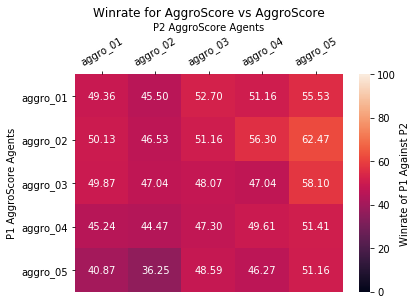

In [46]:
aa_hm = os.path.join(plot_output_dir, 'Aggro-Aggro.pdf')
aa_wr = get_winrates_heatmap_formatchup(aasdf, "AggroScore", "AggroScore", aa_hm)#, colm='magma')

In [29]:
aa_wr.values.reshape(25,1).mean()

49.285199999999996

### Collecting the data for Aggro-Control matchups

In [29]:
ac_folder = root_dir + '\\AvsC_1k0_Compiled\\'
agg_con = gamework.MatchupData('aggro', 'control', ac_folder, 390)
agg_con_folders = agg_con.get_folders()

Roffle-Orasha (7948, 23)
Roffle-Thij (7949, 23)
Roffle-Stonekeep (7368, 23)
Roffle-Slage (7603, 23)
Roffle-Krebs1996 (7237, 23)
Viper-Orasha (8250, 23)
Viper-Thij (8053, 23)
Viper-Stonekeep (7555, 23)
Viper-Slage (7729, 23)
Viper-Krebs1996 (7505, 23)
Pizza-Orasha (8099, 23)
Pizza-Thij (8023, 23)
Pizza-Stonekeep (7550, 23)
Pizza-Slage (7506, 23)
Pizza-Krebs1996 (7309, 23)
Solegit-Orasha (8062, 23)
Solegit-Thij (7726, 23)
Solegit-Stonekeep (7406, 23)
Solegit-Slage (7487, 23)
Solegit-Krebs1996 (7285, 23)
Wabeka-Orasha (8486, 23)
Wabeka-Thij (8367, 23)
Wabeka-Stonekeep (7401, 23)
Wabeka-Slage (7746, 23)
Wabeka-Krebs1996 (7909, 23)
Saved heatmap Winrate for AggroScore vs ControlScore to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\winrate_heatmaps\Aggro-Control.pdf


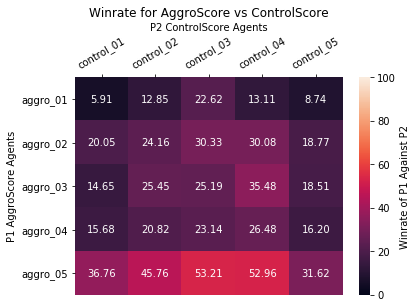

In [48]:
ac_sdf = agg_con.get_all_matchup_summary_data()
ac_hm = os.path.join(plot_output_dir, 'Aggro-Control.pdf')

In [ ]:
acwr = get_winrates_heatmap_formatchup(ac_sdf, "AggroScore", "ControlScore", ac_hm)

In [ ]:
(100 - acwr.values.reshape(25, 1)).mean()

In [ ]:
ac_sdf[list(ac_sdf.columns)[:5]].loc[('Mean-Num-Turns')].mean()

In [34]:
print(get_average_matchup_winrate(ac_sdf))
print(get_average_matchup_winrate(ac_sdf, 2))

0.25076923076923074
0.7501538461538462


### Collecting the data for the Control-Control matchups

In [33]:
cc_folder = root_dir + '\\CvsC_1k0_Compiled\\'
con_con = gamework.MatchupData('control', 'control', cc_folder)
con_con_folders = con_con.get_folders()

In [34]:
cc_sdf = con_con.get_all_matchup_summary_data()
cc_sdf

Orasha-Orasha (17838, 23)
Orasha-Thij (18816, 23)
Orasha-Stonekeep (19644, 23)
Orasha-Slage (17670, 23)
Orasha-Krebs1996 (18972, 23)
Thijs-Orasha (18598, 23)
Thijs-Thij (19268, 23)
Thijs-Stonekeep (20904, 23)
Thijs-Slage (18644, 23)
Thijs-Krebs1996 (20157, 23)
Stonekeep-Orasha (19876, 23)
Stonekeep-Thij (20939, 23)
Stonekeep-Stonekeep (25500, 23)
Stonekeep-Slage (19021, 23)
Stonekeep-Krebs1996 (21139, 23)
Slage-Orasha (17327, 23)
Slage-Thij (17624, 23)
Slage-Stonekeep (18460, 23)
Slage-Slage (16828, 23)
Slage-Krebs1996 (17611, 23)
Krebs1996-Orasha (15127, 23)
Krebs1996-Thij (15592, 23)
Krebs1996-Stonekeep (16065, 23)
Krebs1996-Slage (14141, 23)
Krebs1996-Krebs1996 (15279, 23)


Orasha-Orasha  Orasha-Thij  Orasha-Stonekeep  Orasha-Slage  \
Max-Num-Turns         44.000000    45.000000         51.000000     46.000000   
Mean-Num-Turns        26.270987    27.711340         28.510885     25.947137   
Median-Num-Turns      25.000000    27.000000         28.000000     25.000000   
Min-Num-Turns         15.000000    16.000000         14.000000     15.000000   
Num-Games            680.000000   680.000000        690.000000    682.000000   
P1-NWins             345.000000   266.000000        218.000000    360.000000   
P1-Win%               50.810015    39.175258         31.640058     52.863436   
P2-NWins             336.000000   416.000000        472.000000    323.000000   
P2-Win%               49.484536    61.266568         68.505080     47.430250   
Std-Num-Turns          5.240265     5.528076          6.823370      5.294572   
Var-Num-Turns         27.460381    30.559620         46.558384     28.032495   

                  Orasha-Krebs1996  Thijs-Orasha  Thijs-Thij  Thijs-Stonekeep  \
Max-Num-Turns            47.000000     47.000000   46.000000        52.000000   
Mean-Num-Turns           27.455861     27.390280   28.887556        30.427948   
Median-Num-Turns         26.000000     26.000000   28.000000        30.000000   
Min-Num-Turns            14.000000     12.000000   17.000000        14.000000   
Num-Games               692.000000    680.000000  668.000000       688.000000   
P1-NWins                318.000000    400.000000  351.000000       263.000000   
P1-Win%                  46.020260     58.910162   52.623688        38.282387   
P2-NWins                373.000000    281.000000  319.000000       427.000000   
P2-Win%                  53.979740     41.384389   47.826087        62.154294   
Std-Num-Turns             6.091501      5.526495    5.951073         7.519477   
Var-Num-Turns            37.106382     30.542147   35.415265        56.542541   

                  Thijs-Slage  Thijs-Krebs1996  Stonekeep-Orasha  \
Max-Num-Turns       46.000000        47.000000         49.000000   
Mean-Num-Turns      27.138282        29.170767         28.973761   
Median-Num-Turns    26.000000        29.000000         28.000000   
Min-Num-Turns       16.000000        14.000000         14.000000   
Num-Games          688.000000       692.000000        687.000000   
P1-NWins           427.000000       394.000000        452.000000   
P1-Win%             62.154294        57.018813         65.889213   
P2-NWins           265.000000       296.000000        233.000000   
P2-Win%             38.573508        42.836469         33.965015   
Std-Num-Turns        5.495010         6.332782          7.017343   
Var-Num-Turns       30.195136        40.104130         49.243106   

                  Stonekeep-Thij  Stonekeep-Stonekeep  Stonekeep-Slage  \
Max-Num-Turns          54.000000            57.000000        52.000000   
Mean-Num-Turns         30.657394            36.637931        28.096012   
Median-Num-Turns       30.000000            37.000000        27.000000   
Min-Num-Turns          15.000000            14.000000        12.000000   
Num-Games             684.000000           697.000000       678.000000   
P1-NWins              387.000000           354.000000       453.000000   
P1-Win%                56.661786            50.862069        66.912851   
P2-NWins              297.000000           345.000000       230.000000   
P2-Win%                43.484627            49.568966        33.973412   
Std-Num-Turns           7.622877             9.313930         6.451315   
Var-Num-Turns          58.108255            86.749293        41.619466   

                  Stonekeep-Krebs1996  Slage-Orasha  Slage-Thij  \
Max-Num-Turns               51.000000     44.000000   46.000000   
Mean-Num-Turns              30.459654     25.861194   26.703030   
Median-Num-Turns            30.000000     26.000000   26.000000   
Min-Num-Turns               10.000000     15.000000   15.000000   
Num-Games                  695.000000    67

Saved heatmap Winrate for ControlScore vs ControlScore to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\winrate_heatmaps\Control-Control.pdf


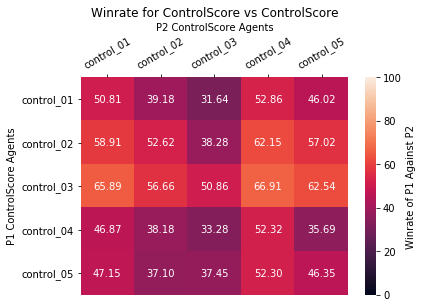

In [49]:
cc_hm = os.path.join(plot_output_dir, 'Control-Control.pdf')
ccwr = get_winrates_heatmap_formatchup(cc_sdf, "ControlScore", "ControlScore", cc_hm)

In [38]:
ccwr.values.reshape(25,1).mean()

48.7616

In [39]:
print(get_average_matchup_winrate(cc_sdf))
print(get_average_matchup_winrate(cc_sdf, 2))

0.4896726062026019
0.5114988593624761


### Collecting the data for Control-NNControl Matchups

In [36]:
cnc1_folder = root_dir + '\\CvsNNC_1k02_Compiled\\'
con_cnc1 = gamework.MatchupData('control', 'nncontrol', cnc1_folder)
#con_cnc1.get_matchups()
con_cnc1_folders = con_cnc1.get_folders()

In [37]:
cnc1_sdf = con_cnc1.get_all_matchup_summary_data()
cnc1_sdf

Orasha-NNOrasha (9270, 23)
Orasha-NNThij (8518, 23)
Orasha-NNStonekeep (8519, 23)
Orasha-NNSlage (9393, 23)
Orasha-NNKrebs1996 (9516, 23)
Thijs-NNOrasha (9672, 23)
Thijs-NNThij (8823, 23)
Thijs-NNStonekeep (8967, 23)
Thijs-NNSlage (9573, 23)
Thijs-NNKrebs1996 (10148, 23)
Stonekeep-NNOrasha (9961, 23)
Stonekeep-NNThij (9180, 23)
Stonekeep-NNStonekeep (9519, 23)
Stonekeep-NNSlage (9752, 23)
Stonekeep-NNKrebs1996 (10463, 23)
Slage-NNOrasha (8808, 23)
Slage-NNThij (8008, 23)
Slage-NNStonekeep (7596, 23)
Slage-NNSlage (8869, 23)
Slage-NNKrebs1996 (8932, 23)
Krebs1996-NNOrasha (9331, 23)
Krebs1996-NNThij (7800, 23)
Krebs1996-NNStonekeep (7520, 23)
Krebs1996-NNSlage (9251, 23)
Krebs1996-NNKrebs1996 (9607, 23)


Orasha-NNOrasha  Orasha-NNThij  Orasha-NNStonekeep  \
Max-Num-Turns           40.000000      38.000000           38.000000   
Mean-Num-Turns          23.647959      21.619289           21.512626   
Median-Num-Turns        23.000000      22.000000           21.000000   
Min-Num-Turns           13.000000      13.000000           13.000000   
Num-Games              393.000000     395.000000          397.000000   
P1-NWins               237.000000     275.000000          237.000000   
P1-Win%                 60.459184      69.796954           59.848485   
P2-NWins               159.000000     119.000000          160.000000   
P2-Win%                 40.561224      30.203046           40.404040   
Std-Num-Turns            5.238413       6.288423            5.502344   
Var-Num-Turns           27.440968      39.544258           30.275790   

                  Orasha-NNSlage  Orasha-NNKrebs1996  Thijs-NNOrasha  \
Max-Num-Turns          40.000000           42.000000       44.000000   
Mean-Num-Turns         23.840102           23.909548       24.863753   
Median-Num-Turns       23.000000           24.000000       25.000000   
Min-Num-Turns          12.000000           13.000000       13.000000   
Num-Games             395.000000          399.000000      390.000000   
P1-NWins              219.000000          191.000000      275.000000   
P1-Win%                55.583756           47.989950       70.694087   
P2-NWins              176.000000          210.000000      115.000000   
P2-Win%                44.670051           52.763819       29.562982   
Std-Num-Turns           4.919434            5.303567        5.535681   
Var-Num-Turns          24.200831           28.127818       30.643760   

                  Thijs-NNThij  Thijs-NNStonekeep  Thijs-NNSlage  \
Max-Num-Turns        41.000000          39.000000      38.000000   
Mean-Num-Turns       23.036554          22.758883      24.420918   
Median-Num-Turns     23.000000          22.000000      24.000000   
Min-Num-Turns        13.000000          11.000000      14.000000   
Num-Games           384.000000         395.000000     393.000000   
P1-NWins            288.000000         281.000000     265.000000   
P1-Win%              75.195822          71.319797      67.602041   
P2-NWins             98.000000         112.000000     128.000000   
P2-Win%              25.587467          28.426396      32.653061   
Std-Num-Turns         6.220530           6.141689       5.054574   
Var-Num-Turns        38.694995          37.720341      25.548717   

                  Thijs-NNKrebs1996  Stonekeep-NNOrasha  Stonekeep-NNThij  \
Max-Num-Turns             45.000000           44.000000         46.000000   
Mean-Num-Turns            25.821883           25.606684         23.299492   
Median-Num-Turns          24.000000           25.000000         22.000000   
Min-Num-Turns             12.000000           13.000000         13.000000   
Num-Games                394.000000          390.000000        395.000000   
P1-NWins                 188.000000          296.000000        328.000000   
P1-Win%                   47.837150           76.092545         83.248731   
P2-NWins                 202.000000           92.000000         68.000000   
P2-Win%                   51.399491           23.650386         17.258883   
Std-Num-Turns              6.398647            6.624467          7.919869   
Var-Num-Turns             40.942683           43.883563         62.724325   

                  Stonekeep-NNStonekeep  Stonekeep-NNSlage  \
Max-Num-Turns                 42.000000          45.000000   
Mean-Num-Turns                23.917085          25.134021   
Median-Num-Turns              23.000000          25.000000   
Min-Num-Turns                 13.000000          10.000000   
Num-Games                    399.000000         389.000000   
P1-NWins                     351.000000         255.000000   
P1-Win%                       88.190955          65.721649   
P2-NWins                      47.000000         13

Saved heatmap Winrate for ControlScore vs EvoControlScore to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\winrate_heatmaps\Control-NNControl_01.pdf


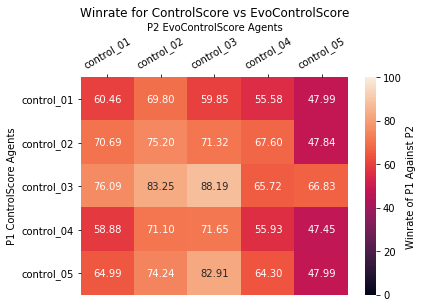

In [50]:
cnc1_hm = os.path.join(plot_output_dir, 'Control-NNControl_01.pdf')
cnc1_wr = get_winrates_heatmap_formatchup(cnc1_sdf, "ControlScore", "EvoControlScore", cnc1_hm)

In [43]:
cnc1_wr.values.reshape(25,1).mean()

65.834

In [45]:
print(get_average_matchup_winrate(cnc1_sdf))
print(get_average_matchup_winrate(cnc1_sdf, 2))

0.6566271169252611
0.342257377547916


##### Below is Control vs NNControl using a different evolved network

In [52]:
cnc2_folder = root_dir + '\\\CvsNNC_2.0_Compiled\\'
con2_cnc = gamework.MatchupData('control', 'nncontrol', cnc2_folder)
#con2_cnc.get_matchups()
con2_cnc_folders = con2_cnc.get_folders()

In [53]:
cnc2_sdf = con2_cnc.get_all_matchup_summary_data()
cnc2_sdf

Orasha-NNOrasha (9361, 23)
Orasha-NNThij (9463, 23)
Orasha-NNStonekeep (9267, 23)
Orasha-NNSlage (8923, 23)
Orasha-NNKrebs1996 (9639, 23)
Thijs-NNOrasha (9996, 23)
Thijs-NNThij (9950, 23)
Thijs-NNStonekeep (10302, 23)
Thijs-NNSlage (9403, 23)
Thijs-NNKrebs1996 (10651, 23)
Stonekeep-NNOrasha (10569, 23)
Stonekeep-NNThij (10617, 23)
Stonekeep-NNStonekeep (12161, 23)
Stonekeep-NNSlage (9905, 23)
Stonekeep-NNKrebs1996 (11402, 23)
Slage-NNOrasha (9089, 23)
Slage-NNThij (9371, 23)
Slage-NNStonekeep (9261, 23)
Slage-NNSlage (8989, 23)
Slage-NNKrebs1996 (9352, 23)
Krebs1996-NNOrasha (9679, 23)
Krebs1996-NNThij (9163, 23)
Krebs1996-NNStonekeep (9266, 23)
Krebs1996-NNSlage (9189, 23)
Krebs1996-NNKrebs1996 (9990, 23)


Orasha-NNOrasha  Orasha-NNThij  Orasha-NNStonekeep  \
Max-Num-Turns           40.000000      38.000000           44.000000   
Mean-Num-Turns          23.941176      24.326478           23.401515   
Median-Num-Turns        23.000000      24.000000           22.000000   
Min-Num-Turns           17.000000      15.000000           13.000000   
Num-Games              392.000000     390.000000          397.000000   
P1-NWins               102.000000     110.000000           58.000000   
P1-Win%                 26.086957      28.277635           14.646465   
P2-NWins               292.000000     280.000000          339.000000   
P2-Win%                 74.680307      71.979434           85.606061   
Std-Num-Turns            4.201845       3.925051            6.064038   
Var-Num-Turns           17.655505      15.406024           36.772555   

                  Orasha-NNSlage  Orasha-NNKrebs1996  Thijs-NNOrasha  \
Max-Num-Turns          37.000000           40.000000       47.000000   
Mean-Num-Turns         22.762755           24.218593       25.500000   
Median-Num-Turns       22.000000           24.000000       25.000000   
Min-Num-Turns          14.000000           12.000000       17.000000   
Num-Games             393.000000          399.000000      393.000000   
P1-NWins              104.000000           85.000000      148.000000   
P1-Win%                26.530612           21.356784       37.755102   
P2-NWins              288.000000          314.000000      249.000000   
P2-Win%                73.469388           78.894472       63.520408   
Std-Num-Turns           4.578650            5.371344        4.901589   
Var-Num-Turns          20.964031           28.851341       24.025575   

                  Thijs-NNThij  Thijs-NNStonekeep  Thijs-NNSlage  \
Max-Num-Turns        40.000000          44.000000      46.000000   
Mean-Num-Turns       26.115486          26.015152      24.172237   
Median-Num-Turns     26.000000          25.000000      24.000000   
Min-Num-Turns        13.000000          13.000000      14.000000   
Num-Games           382.000000         397.000000     390.000000   
P1-NWins            136.000000         104.000000     175.000000   
P1-Win%              35.695538          26.262626      44.987147   
P2-NWins            249.000000         293.000000     215.000000   
P2-Win%              65.354331          73.989899      55.269923   
Std-Num-Turns         4.819620           7.108545       5.445006   
Var-Num-Turns        23.228733          50.531415      29.648093   

                  Thijs-NNKrebs1996  Stonekeep-NNOrasha  Stonekeep-NNThij  \
Max-Num-Turns             44.000000           43.000000         46.000000   
Mean-Num-Turns            27.032995           26.689394         26.946701   
Median-Num-Turns          26.000000           26.000000         26.000000   
Min-Num-Turns             14.000000           15.000000         13.000000   
Num-Games                395.000000          397.000000        395.000000   
P1-NWins                 120.000000          203.000000        219.000000   
P1-Win%                   30.456853           51.262626         55.583756   
P2-NWins                 276.000000          196.000000        178.000000   
P2-Win%                   70.050761           49.494949         45.177665   
Std-Num-Turns              6.673896            5.664635          5.872669   
Var-Num-Turns             44.540893           32.088090         34.488246   

                  Stonekeep-NNStonekeep  Stonekeep-NNSlage  \
Max-Num-Turns                 46.000000          42.000000   
Mean-Num-Turns                30.402500          25.075949   
Median-Num-Turns              31.000000          25.000000   
Min-Num-Turns                 13.000000          12.000000   
Num-Games                    401.000000         396.000000   
P1-NWins                     258.000000         211.000000   
P1-Win%                       64.500000          53.417722   
P2-NWins                     142.000000         18

Saved heatmap Winrate for ControlScore vs EvoControlScore to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\winrate_heatmaps\Control-NNControl_02.pdf


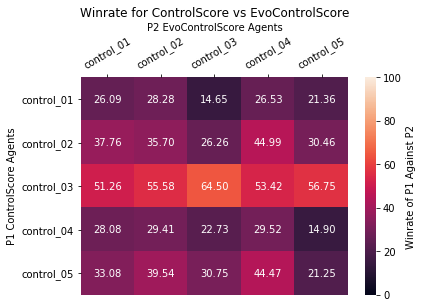

In [55]:
cnc2_hm = os.path.join(plot_output_dir, 'Control-NNControl_02.pdf')
res_df2 = get_winrates_heatmap_formatchup(cnc2_sdf, "ControlScore", "EvoControlScore", cnc2_hm)

In [49]:
print(get_average_matchup_winrate(cnc2_sdf))
print(get_average_matchup_winrate(cnc2_sdf, 2))

0.34626291270002024
0.6540409155357505


In [50]:
res_df2.values.mean()

34.6928

##### Below is Control vs NNControl using an evolved network with a larger search space

In [56]:
cnc3_folder = os.path.join(root_dir, 'CvsNNC_2.0_Large_Compiled\\') 
con3_cnc = gamework.MatchupData('control', 'nncontrol', cnc3_folder)
#con3_cnc.get_matchups()
con3_cnc_folders = con3_cnc.get_folders()

In [57]:
cnc3_sdf = con3_cnc.get_all_matchup_summary_data()
cnc3_sdf

Orasha-NNOrasha (9096, 23)
Orasha-NNThij (9721, 23)
Orasha-NNStonekeep (8619, 23)
Orasha-NNSlage (8467, 23)
Orasha-NNKrebs1996 (9166, 23)
Thijs-NNOrasha (9987, 23)
Thijs-NNThij (9767, 23)
Thijs-NNStonekeep (9590, 23)
Thijs-NNSlage (8797, 23)
Thijs-NNKrebs1996 (9664, 23)
Stonekeep-NNOrasha (10246, 23)
Stonekeep-NNThij (10544, 23)
Stonekeep-NNStonekeep (11663, 23)
Stonekeep-NNSlage (9748, 23)
Stonekeep-NNKrebs1996 (10623, 23)
Slage-NNOrasha (8843, 23)
Slage-NNThij (9088, 23)
Slage-NNStonekeep (8691, 23)
Slage-NNSlage (8359, 23)
Slage-NNKrebs1996 (8881, 23)
Krebs1996-NNOrasha (9687, 23)
Krebs1996-NNThij (9759, 23)
Krebs1996-NNStonekeep (9083, 23)
Krebs1996-NNSlage (9014, 23)
Krebs1996-NNKrebs1996 (9509, 23)


Orasha-NNOrasha  Orasha-NNThij  Orasha-NNStonekeep  \
Max-Num-Turns           38.000000      38.000000           38.000000   
Mean-Num-Turns          24.063492      25.118863           21.765152   
Median-Num-Turns        24.000000      25.000000           22.000000   
Min-Num-Turns           15.000000      15.000000           14.000000   
Num-Games              379.000000     388.000000          397.000000   
P1-NWins               113.000000     141.000000           65.000000   
P1-Win%                 29.894180      36.434109           16.414141   
P2-NWins               269.000000     248.000000          335.000000   
P2-Win%                 71.164021      64.082687           84.595960   
Std-Num-Turns            3.958832       4.241582            4.989903   
Var-Num-Turns           15.672351      17.991016           24.899137   

                  Orasha-NNSlage  Orasha-NNKrebs1996  Thijs-NNOrasha  \
Max-Num-Turns          39.000000           41.000000       39.000000   
Mean-Num-Turns         21.992208           23.030151       25.873057   
Median-Num-Turns       22.000000           22.000000       25.000000   
Min-Num-Turns          12.000000           12.000000       16.000000   
Num-Games             386.000000          399.000000      387.000000   
P1-NWins               98.000000           52.000000      184.000000   
P1-Win%                25.454545           13.065327       47.668394   
P2-NWins              289.000000          347.000000      206.000000   
P2-Win%                75.064935           87.185930       53.367876   
Std-Num-Turns           4.694572            5.389989        4.637728   
Var-Num-Turns          22.039002           29.051985       21.508519   

                  Thijs-NNThij  Thijs-NNStonekeep  Thijs-NNSlage  \
Max-Num-Turns        42.000000          46.000000      41.000000   
Mean-Num-Turns       25.907162          24.909091      22.968668   
Median-Num-Turns     25.000000          24.000000      22.000000   
Min-Num-Turns        17.000000          14.000000      13.000000   
Num-Games           378.000000         386.000000     384.000000   
P1-NWins            185.000000         108.000000     138.000000   
P1-Win%              49.071618          28.051948      36.031332   
P2-NWins            192.000000         278.000000     247.000000   
P2-Win%              50.928382          72.207792      64.490862   
Std-Num-Turns         4.673872           7.142489       5.672480   
Var-Num-Turns        21.845082          51.015152      32.177026   

                  Thijs-NNKrebs1996  Stonekeep-NNOrasha  Stonekeep-NNThij  \
Max-Num-Turns             43.000000           42.000000         42.000000   
Mean-Num-Turns            25.298429           26.612987         27.387013   
Median-Num-Turns          24.000000           26.000000         27.000000   
Min-Num-Turns             13.000000           16.000000         15.000000   
Num-Games                383.000000          386.000000        386.000000   
P1-NWins                  89.000000          211.000000        236.000000   
P1-Win%                   23.298429           54.805195         61.298701   
P2-NWins                 295.000000          177.000000        149.000000   
P2-Win%                   77.225131           45.974026         38.701299   
Std-Num-Turns              6.385264            5.453242          5.260242   
Var-Num-Turns             40.771599           29.737852         27.670143   

                  Stonekeep-NNStonekeep  Stonekeep-NNSlage  \
Max-Num-Turns                 46.000000          43.000000   
Mean-Num-Turns                29.905128          25.385417   
Median-Num-Turns              30.000000          25.000000   
Min-Num-Turns                 14.000000          10.000000   
Num-Games                    391.000000         385.000000   
P1-NWins                     200.000000         191.000000   
P1-Win%                       51.282051          49.739583   
P2-NWins                     192.000000         19

Saved heatmap Winrate for ControlScore vs EvoControlScore to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\winrate_heatmaps\Control-NNControl_Large.pdf


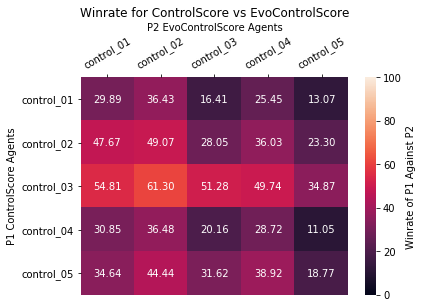

In [59]:
cnc3_hm = os.path.join(plot_output_dir, 'Control-NNControl_Large.pdf')
res_df3 = get_winrates_heatmap_formatchup(cnc3_sdf, "ControlScore", "EvoControlScore", cnc3_hm)

In [54]:
res_df3.values.mean()

34.1208

### Getting Data for Aggro-NNAggro Matchups

In [60]:
ana_folder = root_dir + '\\AvsNNA_1k02_Compiled\\'
agg_ana = gamework.MatchupData('aggro', 'nnaggro', ana_folder)
#agg_ana.get_matchups()
agg_ana_folders = agg_ana.get_folders()

In [61]:
ana_sdf = agg_ana.get_all_matchup_summary_data()

Roffle-NNRoffle (4491, 23)
Roffle-NNViper (4569, 23)
Roffle-NNPizza (4584, 23)
Roffle-NNSolegit (4487, 23)
Roffle-NNWabeka (4712, 23)
Viper-NNRoffle (4186, 23)
Viper-NNViper (4312, 23)
Viper-NNPizza (4074, 23)
Viper-NNSolegit (3950, 23)
Viper-NNWabeka (4252, 23)
Pizza-NNRoffle (3781, 23)
Pizza-NNViper (3866, 23)
Pizza-NNPizza (3930, 23)
Pizza-NNSolegit (3819, 23)
Pizza-NNWabeka (4052, 23)
Solegit-NNRoffle (3765, 23)
Solegit-NNViper (3923, 23)
Solegit-NNPizza (3887, 23)
Solegit-NNSolegit (3873, 23)
Solegit-NNWabeka (4079, 23)
Wabeka-NNRoffle (3971, 23)
Wabeka-NNViper (4158, 23)
Wabeka-NNPizza (4087, 23)
Wabeka-NNSolegit (4013, 23)
Wabeka-NNWabeka (4308, 23)


Saved heatmap Winrate for AggroScore vs EvoAggroScore to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\winrate_heatmaps\Aggro-NNAggro_sm.pdf


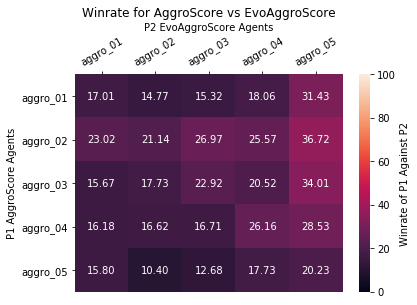

In [62]:
ana_hm = os.path.join(plot_output_dir, 'Aggro-NNAggro_sm.pdf')
anawr = get_winrates_heatmap_formatchup(ana_sdf, "AggroScore", "EvoAggroScore", ana_hm)

In [58]:
anawr.values.reshape(25,1).mean()

20.875999999999998

In [59]:
print(get_average_matchup_winrate(ana_sdf))
print(get_average_matchup_winrate(ana_sdf, 2))

0.2081377151799687
0.7921976302257993


##### Getting Aggro vs Aggro Evolved (Larger Search)

In [63]:
ana2_folder = root_dir + '\\AvsNNA_1k02_large_Compiled\\'
agg_ana2 = gamework.MatchupData('aggro', 'nnaggro', ana2_folder)
#agg_ana.get_matchups()
agg_ana2_folders = agg_ana2.get_folders()

In [64]:
ana2_sdf = agg_ana2.get_all_matchup_summary_data()

Roffle-NNRoffle (4770, 23)
Roffle-NNViper (4701, 23)
Roffle-NNPizza (4724, 23)
Roffle-NNSolegit (4763, 23)
Roffle-NNWabeka (4940, 23)
Viper-NNRoffle (4743, 23)
Viper-NNViper (4745, 23)
Viper-NNPizza (4787, 23)
Viper-NNSolegit (4655, 23)
Viper-NNWabeka (4895, 23)
Pizza-NNRoffle (4512, 23)
Pizza-NNViper (4659, 23)
Pizza-NNPizza (4636, 23)
Pizza-NNSolegit (4651, 23)
Pizza-NNWabeka (4709, 23)
Solegit-NNRoffle (4528, 23)
Solegit-NNViper (4532, 23)
Solegit-NNPizza (4598, 23)
Solegit-NNSolegit (4568, 23)
Solegit-NNWabeka (4691, 23)
Wabeka-NNRoffle (4827, 23)
Wabeka-NNViper (4857, 23)
Wabeka-NNPizza (4847, 23)
Wabeka-NNSolegit (4805, 23)
Wabeka-NNWabeka (5108, 23)


Saved heatmap Winrate for AggroScore vs EvoAggroScore to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\winrate_heatmaps\Aggro-NNAggro_lg.pdf


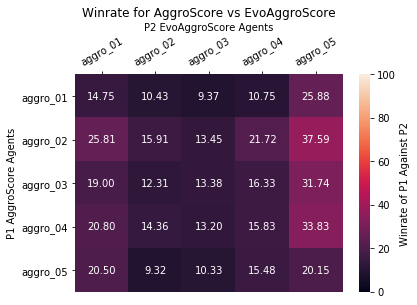

In [65]:
ana2_hm = os.path.join(plot_output_dir, 'Aggro-NNAggro_lg.pdf')
ana2_wr = get_winrates_heatmap_formatchup(ana2_sdf, "AggroScore", "EvoAggroScore", ana2_hm)

In [67]:
ana2_wr.values.mean()

18.0888

### Finally, Evolved Control large vs Evolved Aggro Large

In [66]:
nanc_folder = root_dir + '\\NNAvsNNC_1k02_large_Compiled\\'
nanc = gamework.MatchupData('nnaggro', 'nncontrol', nanc_folder)
#agg_ana.get_matchups()
nanc_folders = nanc.get_folders()

In [67]:
nanc_sdf = nanc.get_all_matchup_summary_data()

NNRoffle-NNOrasha (7208, 23)
NNRoffle-NNThij (6533, 23)
NNRoffle-NNStonekeep (6013, 23)
NNRoffle-NNSlage (6494, 23)
NNRoffle-NNKrebs1996 (6381, 23)
NNViper-NNOrasha (7663, 23)
NNViper-NNThij (7302, 23)
NNViper-NNStonekeep (6662, 23)
NNViper-NNSlage (7080, 23)
NNViper-NNKrebs1996 (6869, 23)
NNPizza-NNOrasha (7545, 23)
NNPizza-NNThij (7216, 23)
NNPizza-NNStonekeep (6621, 23)
NNPizza-NNSlage (6850, 23)
NNPizza-NNKrebs1996 (6880, 23)
NNSolegit-NNOrasha (7509, 23)
NNSolegit-NNThij (6912, 23)
NNSolegit-NNStonekeep (6222, 23)
NNSolegit-NNSlage (6827, 23)
NNSolegit-NNKrebs1996 (6724, 23)
NNWabeka-NNOrasha (7986, 23)
NNWabeka-NNThij (7566, 23)
NNWabeka-NNStonekeep (6796, 23)
NNWabeka-NNSlage (7218, 23)
NNWabeka-NNKrebs1996 (7356, 23)


Saved heatmap Winrate for EvoAggroScore vs EvoControlScore to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\winrate_heatmaps\NNAggro-NNControl_lg.pdf


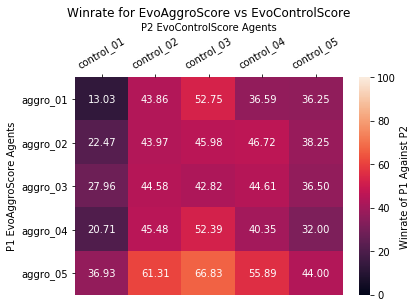

In [68]:
nanc_hm = os.path.join(plot_output_dir, 'NNAggro-NNControl_lg.pdf')
nancwr = get_winrates_heatmap_formatchup(nanc_sdf, "EvoAggroScore", "EvoControlScore", nanc_hm)

In [69]:
nancwr.values.mean()

41.2892

##### The Below Data Set is Only going to be for testing the PCA model

In [221]:
#C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\SabberGameMatchups\EliteMatches_Compiled
elite_folders = [
    'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups\\EliteMatches_Compiled\\Hunter1A-Krebs1996.csv',
    'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups\\EliteMatches_Compiled\\Paladin1A-Krebs1996.csv'
]

# Create a set of Transformed Data

### Default Scoring Functions

In [69]:
aastats = get_matchup_stats(agg_agg_folders, 'aggro', 'aggro')
aastats.shape

(19682, 17)

In [70]:
aastats['PlayerStrategy'].unique()

array([0.])

In [71]:
ccstats = get_matchup_stats(con_con_folders, 'control', 'control')
ccstats.shape

(32388, 17)

In [72]:
ccstats['PlayerStrategy'].unique()

array([1.])

In [73]:
ccstats_half1 = ccstats.iloc[:aastats.shape[0], :]
ccstats_half2 = ccstats.iloc[aastats.shape[0]:, :]

In [74]:
print(aastats.PlayerStrategy.unique())
print(ccstats_half1.PlayerStrategy.unique())

[0.]
[1.]


In [75]:
list(ccstats.columns)

['CurrentPlayer',
 'PlayerStrategy',
 'AvgHealedPerTurn',
 'AvgHeroAttacksPerTurn',
 'AvgCardsDrawnPerTurn',
 'AvgCardsPlayedPerTurn',
 'AvgNumCardsToDraw',
 'AvgFriendlyMinionAttacksPerTurn',
 'AvgFriendlyMinionDeathsPerTurn',
 'AvgMinionsPlayedPerTurn',
 'AvgNumMinionsKilledPerTurn',
 'AvgOptionsPlayedPerTurn',
 'NumSpellsPlayedPerGame',
 'NumHeroPowersUsedPerGame',
 'TotalManaSpentPerGame',
 'AvgRemainingManaPerTurn',
 'AvgManaUsedPerTurn']

* This will be used as the Training and Validation Data in Supervised Learning

In [76]:
mirror_data = pd.concat([aastats, ccstats_half1], sort=False)
print(mirror_data.shape[0] == (aastats.shape[0] + ccstats_half1.shape[0]))
mirror_data.shape

True


(39364, 17)

In [77]:
mirror_data.head()

CurrentPlayer  PlayerStrategy  AvgHealedPerTurn  AvgHeroAttacksPerTurn  \
0            1.0             0.0               0.0                    0.0   
1            2.0             0.0               0.0                    0.0   
2            1.0             0.0               0.0                    0.0   
3            2.0             0.0               0.0                    0.0   
4            1.0             0.0               0.0                    0.0   

   AvgCardsDrawnPerTurn  AvgCardsPlayedPerTurn  AvgNumCardsToDraw  \
0                  1.17                   1.33                0.0   
1                  1.00                   1.33                0.0   
2                  1.00                   1.40                0.0   
3                  1.00                   1.60                0.0   
4                  1.00                   1.17                0.0   

   AvgFriendlyMinionAttacksPerTurn  AvgFriendlyMinionDeathsPerTurn  \
0                             0.67                            0.83   
1                             2.00                            0.00   
2                             1.20                            0.00   
3                             2.80                            0.00   
4                             1.67                            0.00   

   AvgMinionsPlayedPerTurn  AvgNumMinionsKilledPerTurn  \
0                     1.17                        1.33   
1                     0.83                        0.17   
2                     0.60                        0.20   
3                     1.20                        0.00   
4                     0.83                        0.00   

   AvgOptionsPlayedPerTurn  NumSpellsPlayedPerGame  NumHeroPowersUsedPerGame  \
0                     2.00                     1.0                       1.0   
1                     3.33                     3.0                       0.0   
2                     2.60                     4.0                       0.0   
3                     4.40                     2.0                       0.0   
4                     2.83                     2.0                       0.0   

   TotalManaSpentPerGame  AvgRemainingManaPerTurn  AvgManaUsedPerTurn  
0                   14.0                     1.17                2.33  
1                   12.0                     1.67                1.83  
2                   11.0                     0.80                2.20  
3                   10.0                     1.20                1.80  
4                    9.0                     2.00                1.50

In [79]:
mirror_data.shape

(39364, 17)

In [80]:
print(mirror_data.loc[(mirror_data['PlayerStrategy']==0)].shape)
print(mirror_data.loc[(mirror_data['PlayerStrategy']==1)].shape)

(19682, 17)
(19682, 17)


In [498]:
mirror_data.to_csv('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots\\pca_raw.csv')

### Evolved Scoring Functions

* Even though the agent used an evolved scoring function, the root gameplay strategy is "Aggro" - maintain Binomial Classification for now..

In [78]:
anastats1 = get_matchup_stats(agg_ana_folders, 'aggro', 'aggro')
print(anastats1.shape)

anastats2 = get_matchup_stats(agg_ana2_folders, 'aggro', 'aggro')
print(anastats2.shape)

cncstats1 = get_matchup_stats(con_cnc1_folders, 'control', 'control')
print(cncstats1.shape)

cncstats2 = get_matchup_stats(con2_cnc_folders, 'control', 'control')
print(cncstats2.shape)

cncstats3 = get_matchup_stats(con3_cnc_folders, 'control', 'control')
print(cncstats3.shape)

nancstats = get_matchup_stats(nanc_folders, 'aggro', 'control')
print(nancstats.shape)

(17842, 17)
(19862, 17)
(19672, 17)
(19698, 17)
(19288, 17)
(19916, 17)


In [222]:
elites_stats = get_matchup_stats(elite_folders, 'aggro', 'control')


(19916, 15)


In [223]:
print(elites_stats.shape)

(1176, 17)


# Explore Transformed Data

## Boxplots

In [79]:
plt_titles = {
    'AvgHealedPerTurn':'Average Health Healed Per Turn',
    'AvgHeroAttacksPerTurn':'Average Hero Attacks Per Turn',
    'AvgCardsDrawnPerTurn':'Average Number of Cards Drawn Per Turn',
    'AvgCardsPlayedPerTurn':'Average Number of Cards Played Per Turn',
    'AvgNumCardsToDraw':'Average Number of Cards to Draw',
    'AvgFriendlyMinionAttacksPerTurn':'Average Number of Friendly Minion Attacks Per Turn',
    'AvgFriendlyMinionDeathsPerTurn':'Average Number of Friendly Minion Deaths Per Turn',
    'AvgMinionsPlayedPerTurn':'Average Number of Minions Played Per Turn',
    'AvgNumMinionsKilledPerTurn':'Average Number of Enemy Minions Killed Per Turn',
    'AvgOptionsPlayedPerTurn':'Average Number of Tasks Per Turn',
    'NumSpellsPlayedPerGame':'Average Number of Spells Played Per Game',
    'NumHeroPowersUsedPerGame':'Number of Hero Power Activations Per Game',
    'TotalManaSpentPerGame':'Total Mana Spent Per Game',
    'AvgRemainingManaPerTurn':'Average Remaining Mana Per Turn',
    'AvgManaUsedPerTurn':'Average Mana Used Per Turn'
}

In [80]:
#Aggro is 0, Control is 1
aggro_players = mirror_data.loc[(mirror_data['PlayerStrategy']==0)]
control_players = mirror_data.loc[(mirror_data['PlayerStrategy']==1)]

In [81]:
print(aggro_players.shape)
print(control_players.shape)

(19682, 17)
(19682, 17)


In [82]:
from seaborn import boxplot

In [83]:
def make_boxplot(df, xlab, colname, get_title, dest, plot_name):
    ax = boxplot(data=df)
    ax.set_xlabel(xlab)
    plt.title(get_title[colname])
    out_folder = os.path.join(dest, plot_name)
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
        print(out_folder, 'created successfully!')
    #print('All files go to:', out_folder)
    fig_name = os.path.join(out_folder, '{}-{}.pdf'.format(plot_name, colname))
    #print(fig_name)
    plt.savefig(fig_name, format="pdf")
    plt.clf()
    plt.close()

In [84]:
def transformed_data_make_boxplots(df, col_, set1, set2, strat1, strat2):
    pset1 = df.loc[(df[col_]==set1)]
    pset2 = df.loc[(df[col_]==set2)]
    for col in list(df.columns)[2:]:
        temp = pd.concat([pd.Series(pset1[col].values), pd.Series(pset2[col].values)], axis=1)
        temp.columns=[strat1, strat2]
        make_boxplot(temp, 'Scoring Function', col, plt_titles, boxplot_outdir, '-'.join(list(temp.columns)))

In [85]:
boxplot_outdir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\data-boxplots'
for col in list(aggro_players.columns)[2:]:
    #print(col)
    #ad = q_summary(aggro_players[col])
    #cd = q_summary(control_players[col])
    #print(ad, cd, sep='\t')
    #print('________________________________________')



    temp = pd.concat([pd.Series(aggro_players[col].values), pd.Series(control_players[col].values)], axis=1)
    temp.columns=['Aggro', 'Control']
    make_boxplot(temp, 'Scoring Function', col, plt_titles, boxplot_outdir, '-'.join(list(temp.columns)))

In [ ]:
for col in list(aggro_players.columns)[2:]:
    print(col)
    ad = q_summary(aggro_players[col])
    cd = q_summary(control_players[col])
    print(ad, cd, sep='\t')
    print('________________________________________')

# Make Boxplots for 4 Scores Combined in One Plot

In [86]:
anastats2_sub = anastats2.iloc[:19288, :] #player1 is aggroscore, player2 is evolved
#df1.head()
#cncstats3.head() #player1 is controlscore, player2 is evolved

In [87]:
controlScore = cncstats3.loc[(cncstats3['CurrentPlayer']==1)]
evoControlScore = cncstats3.loc[(cncstats3['CurrentPlayer']==2)]
aggroScore = anastats2_sub.loc[(anastats2_sub['CurrentPlayer']==1)]
evoAggroScore = anastats2_sub.loc[(anastats2_sub['CurrentPlayer']==2)]

In [88]:
print(controlScore.shape)
print(evoControlScore.shape)
print(aggroScore.shape)
print(evoAggroScore.shape)

(9644, 17)
(9644, 17)
(9644, 17)
(9644, 17)


In [104]:
len(list(aggroScore.columns)[2:])

15

In [89]:
boxplot_outdir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\data-boxplots'

In [90]:

for col in list(aggroScore.columns)[2:]:
    temp = pd.concat([pd.Series(controlScore[col].values), pd.Series(evoControlScore[col].values),
                     pd.Series(aggroScore[col].values), pd.Series(evoAggroScore[col].values)], axis=1)
    temp.columns=['Control', 'EvoControl', 'Aggro', 'EvoAggro']
    #make_boxplot(temp, 'Scoring Function', col, plt_titles, boxplot_outdir, '-'.join(list(temp.columns)))
    
    
    
    ax = boxplot(data=temp)
    ax.set_xlabel('Scoring Function')
    plt.title(plt_titles[col])
    out_folder = os.path.join(boxplot_outdir, 'All-Scorings')
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
        print(out_folder, 'created successfully!')
    #print('All files go to:', out_folder)
    fig_name = os.path.join(out_folder, '{}-{}.pdf'.format('All-Scorings', col))
    #print(fig_name)
    plt.savefig(fig_name, format="pdf")
    plt.clf()
    plt.close()

## Make Boxplots for Other Matchups

In [91]:
transformed_data_make_boxplots(anastats1, 'CurrentPlayer', 1, 2, 'Aggro', 'NNAggro_sm')
transformed_data_make_boxplots(anastats2, 'CurrentPlayer', 1, 2, 'Aggro', 'NNAggro_lg')
transformed_data_make_boxplots(cncstats1, 'CurrentPlayer', 1, 2, 'Control', 'NNControl_sm1')
transformed_data_make_boxplots(cncstats2, 'CurrentPlayer', 1, 2, 'Control', 'NNControl_sm2')
transformed_data_make_boxplots(cncstats3, 'CurrentPlayer', 1, 2, 'Control', 'NNControl_lg')
transformed_data_make_boxplots(nancstats, 'CurrentPlayer', 1, 2, 'NNAggro_lg', 'NNControl_lg')

* Based on the distributions, it does seem like there are numerical differences in the columns.
* Two columns from the data set are not needed: HeroAttacksPerTurn and AvgNumCardsToDraw.
* These can be dropped because there are no distributions at all.

In [92]:
def remove_columns(df, cols_to_remove):
    cur_cols = list(df.columns)
    for col in cols_to_remove:
        try:
            cur_cols.remove(col)
        except Exception as e:
            print(e)
    return df[cur_cols]

In [93]:
mirror_data = remove_columns(mirror_data, ['AvgHeroAttacksPerTurn', 'AvgNumCardsToDraw'])
anastats1 = remove_columns(anastats1, ['AvgHeroAttacksPerTurn', 'AvgNumCardsToDraw'])
anastats2 = remove_columns(anastats2, ['AvgHeroAttacksPerTurn', 'AvgNumCardsToDraw'])
cncstats1 = remove_columns(cncstats1, ['AvgHeroAttacksPerTurn', 'AvgNumCardsToDraw'])
cncstats2 = remove_columns(cncstats2, ['AvgHeroAttacksPerTurn', 'AvgNumCardsToDraw'])
cncstats3 = remove_columns(cncstats3, ['AvgHeroAttacksPerTurn', 'AvgNumCardsToDraw'])
nancstats = remove_columns(nancstats, ['AvgHeroAttacksPerTurn', 'AvgNumCardsToDraw'])

print(mirror_data.shape)
print(anastats1.shape)
print(anastats2.shape)
print(cncstats1.shape)
print(cncstats2.shape)
print(cncstats3.shape)
print(nancstats.shape)

(39364, 15)
(17842, 15)
(19862, 15)
(19672, 15)
(19698, 15)
(19288, 15)
(19916, 15)


In [ ]:
#transformed_data_make_boxplots(elites_stats, 'CurrentPlayer', 1, 2, 'HP-Aggro', 'WControl')

In [225]:
elites_stats = remove_columns(elites_stats, ['AvgHeroAttacksPerTurn', 'AvgNumCardsToDraw'])
elites_stats.shape

(1176, 15)

## This Stores Evaluation Metrics of Each Model - Must Train Each First

In [94]:
models_metrics = {}

## Train using k-Fold Cross Validation on Supervised Models

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [96]:
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [97]:
def get_model_accuracy(actual, predictions):
    return ((actual == predictions).sum() / (actual == predictions).shape)[0] * 100

In [98]:
#Shuffle the data rows first
#shuf = mirror_data.sample(frac=1, random_state=4)
#X = shuf.iloc[:, 2:] #Stats columns
#print(X.shape)

#y = shuf.iloc[:, 1] #PlayerStrategy
#print(y.shape)

X = mirror_data.iloc[:, 2:] #Stats columns
print(X.shape)

y = mirror_data.iloc[:, 1] #PlayerStrategy
print(y.shape)

(39364, 13)
(39364,)


In [99]:
X.head()

AvgHealedPerTurn  AvgCardsDrawnPerTurn  AvgCardsPlayedPerTurn  \
0               0.0                  1.17                   1.33   
1               0.0                  1.00                   1.33   
2               0.0                  1.00                   1.40   
3               0.0                  1.00                   1.60   
4               0.0                  1.00                   1.17   

   AvgFriendlyMinionAttacksPerTurn  AvgFriendlyMinionDeathsPerTurn  \
0                             0.67                            0.83   
1                             2.00                            0.00   
2                             1.20                            0.00   
3                             2.80                            0.00   
4                             1.67                            0.00   

   AvgMinionsPlayedPerTurn  AvgNumMinionsKilledPerTurn  \
0                     1.17                        1.33   
1                     0.83                        0.17   
2                     0.60                        0.20   
3                     1.20                        0.00   
4                     0.83                        0.00   

   AvgOptionsPlayedPerTurn  NumSpellsPlayedPerGame  NumHeroPowersUsedPerGame  \
0                     2.00                     1.0                       1.0   
1                     3.33                     3.0                       0.0   
2                     2.60                     4.0                       0.0   
3                     4.40                     2.0                       0.0   
4                     2.83                     2.0                       0.0   

   TotalManaSpentPerGame  AvgRemainingManaPerTurn  AvgManaUsedPerTurn  
0                   14.0                     1.17                2.33  
1                   12.0                     1.67                1.83  
2                   11.0                     0.80                2.20  
3                   10.0                     1.20                1.80  
4                    9.0                     2.00                1.50

In [100]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: PlayerStrategy, dtype: float64

In [101]:
y.unique()

array([0., 1.])

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=4
)

In [103]:
# standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
#logreg = LogisticRegression(solver='liblinear', random_state=4)
#scores = cross_val_score(logreg, X, y, cv=5, scoring='accuracy').mean()

#### Logistic Regression

In [104]:
logreg = LogisticRegression(solver='liblinear', random_state=4)
hyperparameters = {
    'penalty':['l1', 'l2'],
    'C':[0.1, 1, 10, 100]
}

In [105]:
now = time.time()
logreg_gs = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
logreg_gs.fit(X_train_std, y_train);
print('Time to fit {}: {}'.format('GridSearch LogReg', get_time_difference(now)))
lrbest_model = logreg_gs.best_estimator_
print('Best Penalty:', lrbest_model.get_params()['penalty'])
print('Best C:', lrbest_model.get_params()['C'])
print('Best training score:', logreg_gs.best_score_*100)
print('\n',logreg_gs.best_params_)

Time to fit GridSearch LogReg: 6.41 seconds
Best Penalty: l2
Best C: 10
Best training score: 99.9201567830442

 {'C': 10, 'penalty': 'l2'}


In [106]:
lrgspreds = lrbest_model.predict(X_test_std)
get_model_accuracy(y_test, lrgspreds)

99.8645215918713

In [107]:
def make_roc_curve(y_true, y_preds, model, save_figure=False, save_dir=None):    
    fpr, tpr, thresholds = roc_curve(y_true, y_preds)
    auc_score = roc_auc_score(y_true, y_preds)
    plt.plot(fpr, tpr)
    plt.text(0.3, 0.5, 'AUC = {:.3f}'.format(auc_score),
            fontdict={'family': 'serif','weight': 'bold','size': 16, 'color':'darkred'})
    plt.fill_between(fpr, 0, tpr, alpha=0.2)
    plt.title('{} ROC Curve'.format(model))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if save_figure and save_dir is not None:
        save_dir = os.path.join(thesisoutput_dir, 'roc-plots')
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
            print('Made directory: {}'.format(save_dir))
        fname = os.path.join(save_dir, '{}.pdf'.format(model))
        plt.savefig(fname, format='pdf')
        print('Saved ROC Curve to', fname)

In [108]:
thesisoutput_dir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\'

Saved ROC Curve to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\roc-plots\Logistic Regression.pdf


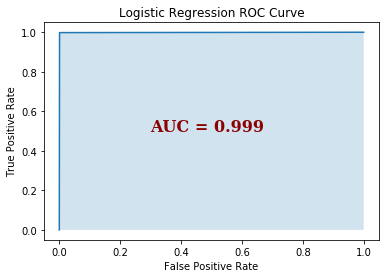

In [109]:
make_roc_curve(y_test, lrgspreds, 'Logistic Regression', save_figure=True, save_dir = thesisoutput_dir)

In [110]:
lr_acc = accuracy_score(y_test, lrgspreds)
#lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lrgspreds)
lr_rec = recall_score(y_test, lrgspreds)
lr_pre = precision_score(y_test, lrgspreds)
lr_f1 = f1_score(y_test, lrgspreds)
lrauc_score = roc_auc_score(y_test, lrgspreds)
models_metrics['Logistic-Regression'] = [lr_acc, lr_rec, lr_pre, lr_f1, lrauc_score]

#### Random Forest

In [111]:
now = time.time()
rf = RandomForestClassifier()
params_rf = {'n_estimators': [50, 100, 200]}
rf_gs = GridSearchCV(rf, params_rf, cv=5)
rf_gs.fit(X_train_std, y_train);
print('Time to fit {}: {}'.format('GridSearch RandFor', get_time_difference(now)))
rfbest_model = rf_gs.best_estimator_
print('Best number of estimators:', rfbest_model.get_params()['n_estimators'])
print('Best training score', rf_gs.best_score_*100)

Time to fit GridSearch RandFor: 29.98 seconds
Best number of estimators: 50
Best training score 99.86934746316324


In [112]:
rfgspreds = rfbest_model.predict(X_test_std)
get_model_accuracy(y_test, rfgspreds)

99.91532599491956

Saved ROC Curve to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\roc-plots\Random Forest.pdf


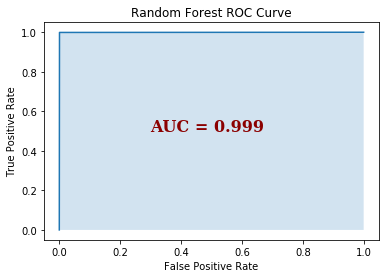

In [113]:
make_roc_curve(y_test, rfgspreds, 'Random Forest', save_figure=True, save_dir = thesisoutput_dir)

In [114]:
rf_acc = accuracy_score(y_test, rfgspreds)
#lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lrgspreds)
rf_rec = recall_score(y_test, rfgspreds)
rf_pre = precision_score(y_test, rfgspreds)
rf_f1 = f1_score(y_test, rfgspreds)
rfauc_score = roc_auc_score(y_test, rfgspreds)
models_metrics['Random-Forest'] = [rf_acc, rf_rec, rf_pre, rf_f1, rfauc_score]

#### Support Vector Classifier (Linear)

In [115]:
svc = LinearSVC(loss='squared_hinge', random_state=4, dual=False)

param_grid = {
                'penalty':['l1', 'l2'],
                'C': [0.1, 1, 10, 100],  
                #'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                #'kernel': ['rbf'] #kernel is linear
}  

In [116]:
now = time.time()
svc_gs = GridSearchCV(svc, param_grid, cv=5) #refit = True, verbose = 3) 
svc_gs.fit(X_train_std, y_train);
print('Time to fit {}: {}'.format('GridSearch LinearSVC', get_time_difference(now)))
svcbest_model = svc_gs.best_estimator_
print('Best number for C:', svcbest_model.get_params()['C'])
print('Best Penalty:', svcbest_model.get_params()['penalty'])
print('Best training score', svc_gs.best_score_*100)

Time to fit GridSearch LinearSVC: 7.89 seconds
Best number for C: 1
Best Penalty: l2
Best training score 99.9201567830442


In [117]:
svcgspreds = svcbest_model.predict(X_test_std)
get_model_accuracy(y_test, svcgspreds)

99.87298899237935

Saved ROC Curve to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\roc-plots\Support Vector Classifier.pdf


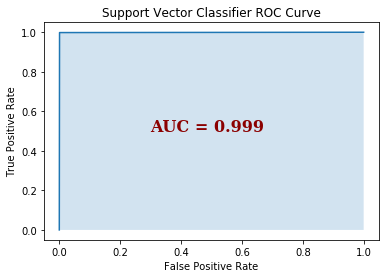

In [118]:
make_roc_curve(y_test, svcgspreds, 'Support Vector Classifier', save_figure=True, save_dir = thesisoutput_dir)

In [119]:
sv_acc = accuracy_score(y_test, svcgspreds)
#lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lrgspreds)
sv_rec = recall_score(y_test, svcgspreds)
sv_pre = precision_score(y_test, svcgspreds)
sv_f1 = f1_score(y_test, svcgspreds)
svauc_score = roc_auc_score(y_test, svcgspreds)
models_metrics['Support-Vector-Classifier'] = [sv_acc, sv_rec, sv_pre, sv_f1, svauc_score]

#### Decision Tree Classifier

In [120]:
dt = DecisionTreeClassifier(random_state=4)

dt_params = {
    'criterion':['gini', 'entropy'],
    'splitter':['best', 'random'],
    'max_depth':[4,5,6,7,8,9,10]
}

In [121]:
now = time.time()
dt_gs = GridSearchCV(dt, dt_params, cv=5) #refit = True, verbose = 3) 
dt_gs.fit(X_train_std, y_train);
print('Time to fit {}: {}'.format('GridSearch DecisionTree', get_time_difference(now)))
dtbest_model = dt_gs.best_estimator_
print('Best splitter:', dtbest_model.get_params()['splitter'])
print('Best max_depth:', dtbest_model.get_params()['max_depth'])
print('Best criterion:', dtbest_model.get_params()['criterion'])
print('Best training score', dt_gs.best_score_*100)

Time to fit GridSearch DecisionTree: 7.59 seconds
Best splitter: best
Best max_depth: 10
Best criterion: entropy
Best training score 99.82942585468535


In [122]:
dtgspreds = dtbest_model.predict(X_test_std)
get_model_accuracy(y_test, dtgspreds)

99.80524978831498

Saved ROC Curve to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\roc-plots\Decision Tree.pdf


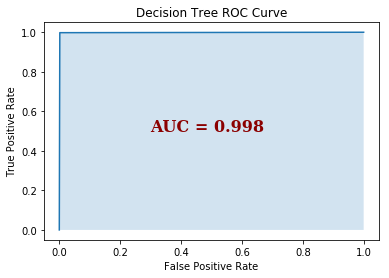

In [123]:
make_roc_curve(y_test, dtgspreds, 'Decision Tree', save_figure=True, save_dir = thesisoutput_dir)

In [124]:
dt_acc = accuracy_score(y_test, dtgspreds)
#lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lrgspreds)
dt_rec = recall_score(y_test, dtgspreds)
dt_pre = precision_score(y_test, dtgspreds)
dt_f1 = f1_score(y_test, dtgspreds)
dtauc_score = roc_auc_score(y_test, dtgspreds)
models_metrics['Decision-Tree'] = [dt_acc, dt_rec, dt_pre, dt_f1, dtauc_score]

#### Stochastic Gradient Descent Classifier

In [125]:
sgd_hyperparams = {
    'loss':['hinge', 'log', 'perceptron', 'modified_huber'],
    'penalty':['l1','l2'],
    'alpha':[1, 0.1, 0.01, 0.001, 0.0001],
    'tol':[0.001, 0.0001]
}
sgd = SGDClassifier(shuffle=True, random_state=4, max_iter=500)


In [126]:
now = time.time()
sgd_gs = GridSearchCV(sgd, sgd_hyperparams, cv=5) #refit = True, verbose = 3) 
sgd_gs.fit(X_train_std, y_train);
print('Time to fit {}: {}'.format('GridSearch SGDClassifies', get_time_difference(now)))
sgdbest_model = sgd_gs.best_estimator_
print('Best loss function:', sgdbest_model.get_params()['loss'])
print('Best penalty:', sgdbest_model.get_params()['penalty'])
print('Best alpha:', sgdbest_model.get_params()['alpha'])
print('Best training score', sgd_gs.best_score_*100)

Time to fit GridSearch SGDClassifies: 30.21 seconds
Best loss function: modified_huber
Best penalty: l2
Best alpha: 0.001
Best training score 99.9201567830442


In [127]:
sgdgspreds = sgdbest_model.predict(X_test_std)
get_model_accuracy(y_test, sgdgspreds)

99.88145639288739

Saved ROC Curve to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\roc-plots\Stochastic Gradient Descent Classifier.pdf


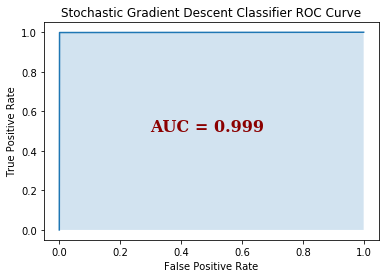

In [128]:
make_roc_curve(y_test, sgdgspreds, 'Stochastic Gradient Descent Classifier', save_figure=True, save_dir = thesisoutput_dir)

In [129]:
sg_acc = accuracy_score(y_test, sgdgspreds)
#lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lrgspreds)
sg_rec = recall_score(y_test, sgdgspreds)
sg_pre = precision_score(y_test, sgdgspreds)
sg_f1 = f1_score(y_test, sgdgspreds)
sgauc_score = roc_auc_score(y_test, sgdgspreds)
models_metrics['SGD-Classifier'] = [sg_acc, sg_rec, sg_pre, sg_f1, sgauc_score]

### Observe Model Metrics Results

In [130]:
model_performance = pd.DataFrame.from_dict(models_metrics, orient='index', columns=['Accuracy', 'Recall', 'Precision', 'F1-Score', 'AUC']).round(4)
model_performance

Accuracy  Recall  Precision  F1-Score     AUC
Logistic-Regression          0.9986  0.9981     0.9992    0.9986  0.9986
Random-Forest                0.9992  0.9990     0.9993    0.9992  0.9992
Support-Vector-Classifier    0.9987  0.9983     0.9992    0.9987  0.9987
Decision-Tree                0.9981  0.9978     0.9983    0.9981  0.9981
SGD-Classifier               0.9988  0.9985     0.9992    0.9988  0.9988

In [131]:
model_performance.to_csv('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\model_metrics.csv')

## Use Other Test Data to Predict

In [132]:

X_mtest = nancstats.iloc[:, 2:]
print(X_mtest.shape)

y_mtest = nancstats.iloc[:, 1]
print(y_mtest.shape)

(19916, 13)
(19916,)


In [133]:
X_mtest_std = sc.transform(X_mtest)

In [134]:
model_metrics_m = {}

##### Logistic Regression

In [135]:
lrgspredsm = lrbest_model.predict(X_mtest_std)
get_model_accuracy(y_mtest, lrgspredsm)

61.05643703554931

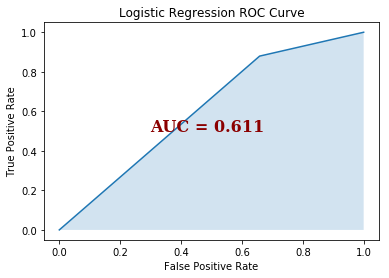

In [136]:
make_roc_curve(y_mtest, lrgspredsm, 'Logistic Regression')

In [137]:
lr_accm = accuracy_score(y_mtest, lrgspredsm)
#lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lrgspreds)
lr_recm = recall_score(y_mtest, lrgspredsm)
lr_prem = precision_score(y_mtest, lrgspredsm)
lr_f1m = f1_score(y_mtest, lrgspredsm)
lrauc_scorem = roc_auc_score(y_mtest, lrgspredsm)
model_metrics_m['Logistic-Regression'] = [lr_accm, lr_recm, lr_prem, lr_f1m, lrauc_scorem]

##### Random Forest

In [138]:
rfgspredsm = rfbest_model.predict(X_mtest_std)
get_model_accuracy(y_mtest, rfgspredsm)

66.36372765615586

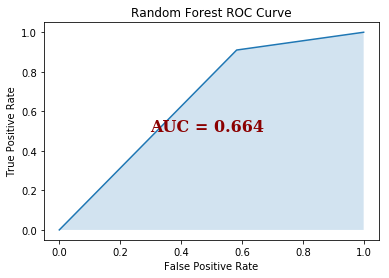

In [139]:
make_roc_curve(y_mtest, rfgspredsm, 'Random Forest')

In [140]:
rf_accm = accuracy_score(y_mtest, rfgspredsm)
#lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lrgspreds)
rf_recm = recall_score(y_mtest, rfgspredsm)
rf_prem = precision_score(y_mtest, rfgspredsm)
rf_f1m = f1_score(y_mtest, rfgspredsm)
rfauc_scorem = roc_auc_score(y_mtest, rfgspredsm)
model_metrics_m['Random-Forest'] = [rf_accm, rf_recm, rf_prem, rf_f1m, rfauc_scorem]

##### Support Vector Classifier

In [141]:
svcgspredsm = svcbest_model.predict(X_mtest_std)
get_model_accuracy(y_mtest, svcgspredsm)

61.20204860413738

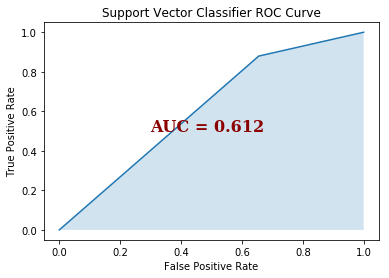

In [142]:
make_roc_curve(y_mtest, svcgspredsm, 'Support Vector Classifier')

In [143]:
sv_accm = accuracy_score(y_mtest, svcgspredsm)
#lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lrgspreds)
sv_recm = recall_score(y_mtest, svcgspredsm)
sv_prem = precision_score(y_mtest, svcgspredsm)
sv_f1m = f1_score(y_mtest, svcgspredsm)
svauc_scorem = roc_auc_score(y_mtest, svcgspredsm)
model_metrics_m['Support-Vector-Classifier'] = [sv_accm, sv_recm, sv_prem, sv_f1m, svauc_scorem]

##### Decision Tree Classifier

In [144]:
dtgspredsm = dtbest_model.predict(X_mtest_std)
get_model_accuracy(y_mtest, dtgspredsm)

68.16629845350471

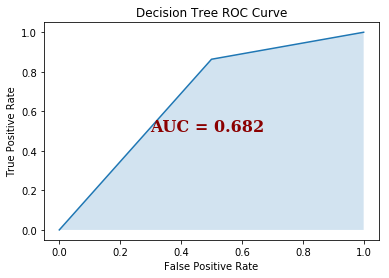

In [145]:
make_roc_curve(y_mtest, dtgspredsm, 'Decision Tree')

In [146]:
dt_accm = accuracy_score(y_mtest, dtgspredsm)
#lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lrgspreds)
dt_recm = recall_score(y_mtest, dtgspredsm)
dt_prem = precision_score(y_mtest, dtgspredsm)
dt_f1m = f1_score(y_mtest, dtgspredsm)
dtauc_scorem = roc_auc_score(y_mtest, dtgspredsm)
model_metrics_m['Decision-Tree'] = [dt_accm, dt_recm, dt_prem, dt_f1m, dtauc_scorem]

##### SGD Classifier

In [147]:
sgdgspredsm = sgdbest_model.predict(X_mtest_std)
get_model_accuracy(y_mtest, sgdgspredsm)

62.44727856999397

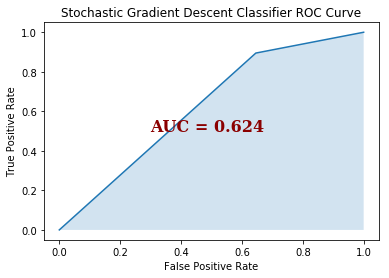

In [148]:
make_roc_curve(y_mtest, sgdgspredsm, 'Stochastic Gradient Descent Classifier')

In [149]:
sg_accm = accuracy_score(y_mtest, sgdgspredsm)
#lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lrgspreds)
sg_recm = recall_score(y_mtest, sgdgspredsm)
sg_prem = precision_score(y_mtest, sgdgspredsm)
sg_f1m = f1_score(y_mtest, sgdgspredsm)
sgauc_scorem = roc_auc_score(y_mtest, sgdgspredsm)
model_metrics_m['SGD-Classifier'] = [sg_accm, sg_recm, sg_prem, sg_f1m, sgauc_scorem]

## Observe Model Metrics Results over NN Test Data

In [150]:
model_performancem = pd.DataFrame.from_dict(model_metrics_m, orient='index', columns=['Accuracy', 'Recall', 'Precision', 'F1-Score', 'AUC']).round(4)
model_performancem

Accuracy  Recall  Precision  F1-Score     AUC
Logistic-Regression          0.6106  0.8793     0.5719    0.6931  0.6106
Random-Forest                0.6636  0.9100     0.6096    0.7301  0.6636
Support-Vector-Classifier    0.6120  0.8794     0.5730    0.6939  0.6120
Decision-Tree                0.6817  0.8634     0.6332    0.7306  0.6817
SGD-Classifier               0.6245  0.8947     0.5808    0.7044  0.6245

In [151]:
model_performancem.to_csv('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\model_metrics_test.csv')

##### Scratch Work Below

In [ ]:
#clf = LogisticRegression(random_state=0, solver='liblinear')
#clf.fit(X, y)

In [ ]:
"""d = {
    
}
for i in range(2, 11):
    cv_results = cross_validate(clf, X, y, cv=i, return_train_score=True, scoring='accuracy', return_estimator=True)
    d[i] = {
        'fit_time':cv_results['fit_time'],
        'score_time':cv_results['score_time'],
        'test_score':cv_results['test_score'],
        'train_score':cv_results['train_score'],
        'estimator':cv_results['estimator']
    }
"""

In [ ]:
"""for kfold in d:
    print(kfold)
    for metric in d[kfold]:
        if metric != 'estimator':
            print(metric, np.round(d[kfold][metric],2), end='\n')
    print()"""

# Use PCA to Reduce Dimensions of Averaged Data

In [ ]:
pcaTRY = PCA()
X_train_pcaTRY = pd.DataFrame(pcaTRY.fit_transform(X_train_std))
X_test_pcaTRY = pcaTRY.transform(X_test_std)

In [ ]:
pcaTRY.explained_variance_ratio_.sum()

In [ ]:
pd.DataFrame(pcaTRY.explained_variance_)

##### Start here

In [152]:
pca = PCA(n_components=2)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_std))
X_test_pca = pca.transform(X_test_std)

In [153]:
X_train_pca.shape[0]//2

13777

* PCA reportings need Scores, Loadings, and %Variance Explained by each PCA
* Score - each data point
* % Variance Explained - pca.explained_variance_ - an array with number entries == num components
* Loading - Correlation of the colum to the component. Column (i) loads NUMBER onto the component
* Loading - >0.7 column loads high < 0.3 column loads low
* https://ostwalprasad.github.io/machine-learning/PCA-using-python.html
* https://github.com/ostwalprasad/ostwalprasad.github.io/blob/master/jupyterbooks/2019-01-20-PCA%20using%20python.ipynb
* https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
* https://blog.bioturing.com/2018/06/18/how-to-read-pca-biplots-and-scree-plots/

In [154]:
pc1_explainedV = pca.explained_variance_ratio_[0]*100
pc2_explainedV = pca.explained_variance_ratio_[1]*100

In [155]:
load_cols = [
    'Healed',
    'CardsDrawn',
    'CardsPlayed',
    'MinionAttacks',
    'MinionDeaths',
    'MinionsPlayed',
    'MinionsKilled',
    'OptionsPlayed',
    'SpellsPlayedGame',
    'HeroPowerGame',
    'ManaSpentGame',
    'ManaLeft',
    'ManaUsed'
]

In [156]:
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns=['PC-1', 'PC-2'], index=X.columns) 
loadings
#loadings are the pearson correlation of the columns to the component
#column loads NUMBER onto the component

PC-1      PC-2
AvgHealedPerTurn                 0.585659  0.057622
AvgCardsDrawnPerTurn             0.498682  0.326378
AvgCardsPlayedPerTurn           -0.269463  0.810918
AvgFriendlyMinionAttacksPerTurn -0.833616  0.129601
AvgFriendlyMinionDeathsPerTurn   0.031673  0.608543
AvgMinionsPlayedPerTurn         -0.405938  0.621650
AvgNumMinionsKilledPerTurn       0.411815  0.544534
AvgOptionsPlayedPerTurn         -0.817607  0.361908
NumSpellsPlayedPerGame           0.778460  0.193658
NumHeroPowersUsedPerGame         0.776218  0.190300
TotalManaSpentPerGame            0.918443  0.156754
AvgRemainingManaPerTurn          0.490319 -0.412867
AvgManaUsedPerTurn               0.888831  0.219130

In [157]:
#X.columns
pca_exvar = pd.DataFrame(pca.components_,columns=load_cols,index = ['PC-1','PC-2']).T.sort_values(by='PC-1')
pca_exvar

PC-1      PC-2
MinionAttacks    -0.357228  0.085732
OptionsPlayed    -0.350368  0.239403
MinionsPlayed    -0.173956  0.411223
CardsPlayed      -0.115472  0.536425
MinionDeaths      0.013573  0.402553
MinionsKilled     0.176474  0.360211
ManaLeft          0.210115 -0.273113
CardsDrawn        0.213699  0.215900
Healed            0.250971  0.038117
HeroPowerGame     0.332631  0.125884
SpellsPlayedGame  0.333592  0.128105
ManaUsed          0.380889  0.144955
ManaSpentGame     0.393578  0.103693

In [158]:
X_test_pcadf = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2'])

In [159]:
y_train.head()

1102    1.0
1126    1.0
455     0.0
339     1.0
230     1.0
Name: PlayerStrategy, dtype: float64

In [160]:
temp_pca_df = X_train_pca.copy()
temp_pca_df.columns = ['PC1', 'PC2']
temp_pca_df.head(10)

PC1       PC2
0  3.208162  0.816981
1  0.271223  0.038418
2 -3.389369  1.468547
3  1.796295  0.552106
4  3.116582  0.256812
5  0.851770  0.539721
6  0.411251 -0.973702
7 -1.257520 -0.065270
8 -3.136493  1.774083
9  3.554161  2.127731

In [161]:
temp_pca_df.insert(0, 'y', y_train.values)
temp_pca_df.head(10)

y       PC1       PC2
0  1.0  3.208162  0.816981
1  1.0  0.271223  0.038418
2  0.0 -3.389369  1.468547
3  1.0  1.796295  0.552106
4  1.0  3.116582  0.256812
5  1.0  0.851770  0.539721
6  1.0  0.411251 -0.973702
7  0.0 -1.257520 -0.065270
8  0.0 -3.136493  1.774083
9  1.0  3.554161  2.127731

In [162]:
temp_agg0 = temp_pca_df.loc[(temp_pca_df['y']==0)]
temp_con1 = temp_pca_df.loc[(temp_pca_df['y']==1)]

In [163]:
print(temp_agg0.shape)
print(temp_con1.shape)

(13777, 3)
(13777, 3)


##### Make a biplot

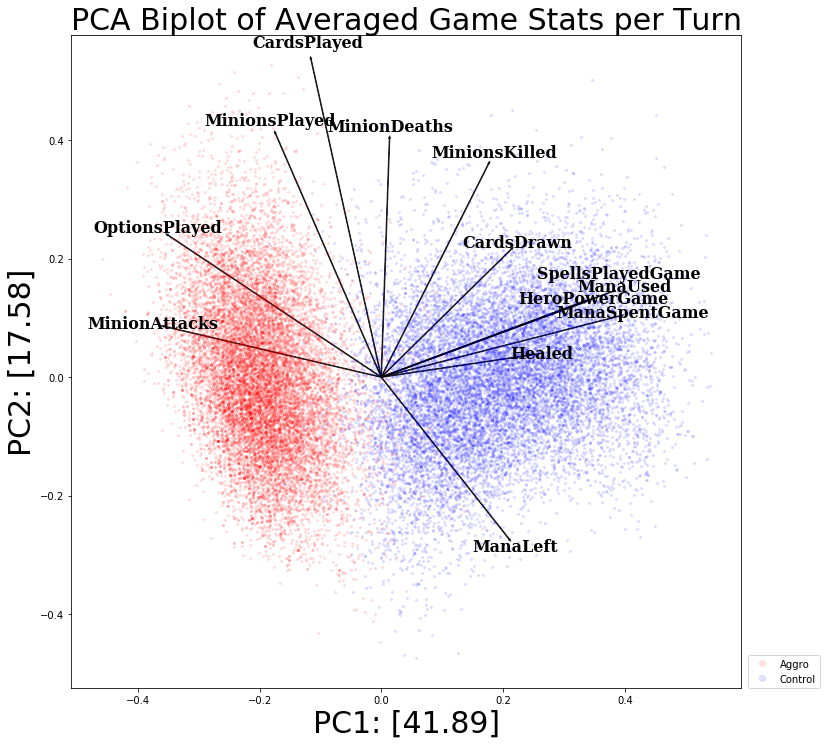

In [164]:
#scores = X_train_pca    #score
#pca_exvar              #coeff
#labels = list(X.columns)


x1_scores = X_train_pca.iloc[:, 0]
x2_scores = X_train_pca.iloc[:, 1]
n = pca_exvar.shape[0] # 13 columns in the original data set

x1_scale = 1.0 / (x1_scores.max() - x1_scores.min())
x2_scale = 1.0 / (x2_scores.max() - x2_scores.min())

#plt.scatter(x1_scores * x1_scale, x2_scores * x2_scale, s=5, c='grey', alpha=0.4)
plt.plot(temp_agg0['PC1']*x1_scale, temp_agg0['PC2']*x2_scale, 'o', c='red', markersize=2, alpha=0.1, label='Aggro')
plt.plot(temp_con1['PC1']*x1_scale, temp_con1['PC2']*x2_scale, 'o', c='blue', markersize=2, alpha=0.1, label='Control')
for i in range(n):
    plt.arrow(x=0, y=0, dx=pca_exvar.iloc[i,0], dy=pca_exvar.iloc[i,1], color='black', alpha=0.8)
    if list(pca_exvar.index)[i] == 'SpellsPlayedGame':
        dist = (i*0.004)
    else:
        dist = 0
    plt.text(pca_exvar.iloc[i,0]*1.05+(dist), pca_exvar.iloc[i,1]*1.05+(dist),
            list(pca_exvar.index)[i], color='black', ha='center', va='center',
            fontdict={'family': 'serif','weight': 'bold','size': 16}) #'color':  'darkred'
plt.gcf().set_size_inches(12, 12)
plt.title('PCA Biplot of Averaged Game Stats per Turn', fontdict={'fontsize':30})
plt.xlabel('PC1: [{:.2f}]'.format(pc1_explainedV), fontdict={'fontsize':30})
plt.ylabel('PC2: [{:.2f}]'.format(pc2_explainedV), fontdict={'fontsize':30})
lgnd = plt.legend(loc=(1.01,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
plt.savefig('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots\\biplot_color.pdf', format='pdf')
plt.show()    #SpellsPlayed and Hero Power are overlapping

In [165]:
pca_output = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots'

Saved PCA plot to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\pca-plots\base_pca_nolabels.pdf


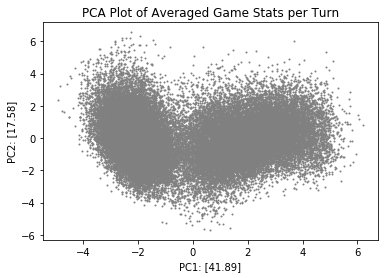

In [167]:
save_figure = True
pca_output_base = os.path.join(pca_output, 'base_pca_nolabels.pdf')
#aggro is 0, control is 1
plt.plot(temp_agg0['PC1'], temp_agg0['PC2'], 'o', c='grey', markersize=1)#, label='Aggro')
plt.plot(temp_con1['PC1'], temp_con1['PC2'], 'o', c='grey', markersize=1)#, label='Control')
plt.plot(X_test_pcadf['PC1'], X_test_pcadf['PC2'], 'o', c='grey', markersize=1)#, label='?')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==0].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==0].index), 1], 'o', c='blue')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==1].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==1].index), 1], 'x', c='red')
#plt.plot(X_test_pca[:, 0], X_test_pca[:, 1], 'x', c='red')
plt.title('PCA Plot of Averaged Game Stats per Turn')
plt.xlabel('PC1: [{:.2f}]'.format(pc1_explainedV))
plt.ylabel('PC2: [{:.2f}]'.format(pc2_explainedV))
#lgnd = plt.legend(loc=(1.04,0))
#for i in range(len(lgnd.legendHandles)):
#    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig(pca_output_base, format='pdf', bbox_extra_artists=(lgnd,), bbox_inches='tight')
    print('Saved PCA plot to', pca_output_base)
plt.show()

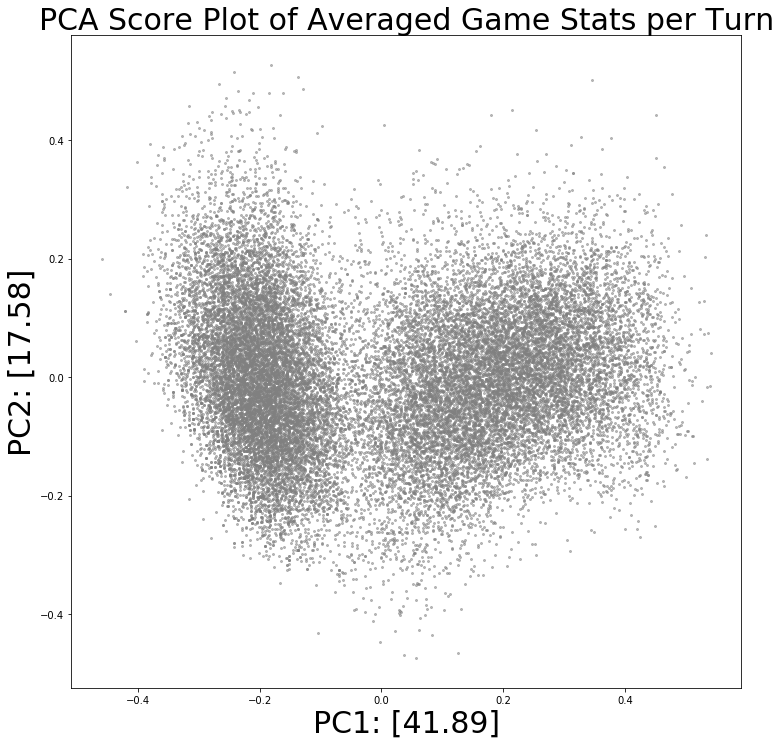

In [168]:
#scores = X_train_pca    #score
#pca_exvar              #coeff
#labels = list(X.columns)

save_figure = True
x1_scores = X_train_pca.iloc[:, 0]
x2_scores = X_train_pca.iloc[:, 1]
n = pca_exvar.shape[0] # 13 columns in the original data set

x1_scale = 1.0 / (x1_scores.max() - x1_scores.min())
x2_scale = 1.0 / (x2_scores.max() - x2_scores.min())

#plt.scatter(x1_scores * x1_scale, x2_scores * x2_scale, s=5, c='grey', alpha=0.4)
plt.plot(temp_agg0['PC1']*x1_scale, temp_agg0['PC2']*x2_scale, 'o', c='grey', markersize=2, alpha=0.5)
plt.plot(temp_con1['PC1']*x1_scale, temp_con1['PC2']*x2_scale, 'o', c='grey', markersize=2, alpha=0.5)
plt.gcf().set_size_inches(12, 12)
plt.title('PCA Score Plot of Averaged Game Stats per Turn', fontdict={'fontsize':30})
plt.xlabel('PC1: [{:.2f}]'.format(pc1_explainedV), fontdict={'fontsize':30})
plt.ylabel('PC2: [{:.2f}]'.format(pc2_explainedV), fontdict={'fontsize':30})
#lgnd = plt.legend(loc=(1.01,0))
#for i in range(len(lgnd.legendHandles)):
#    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots\\base_pca_grey.pdf', format='pdf')
plt.show()    #SpellsPlayed and Hero Power are overlapping

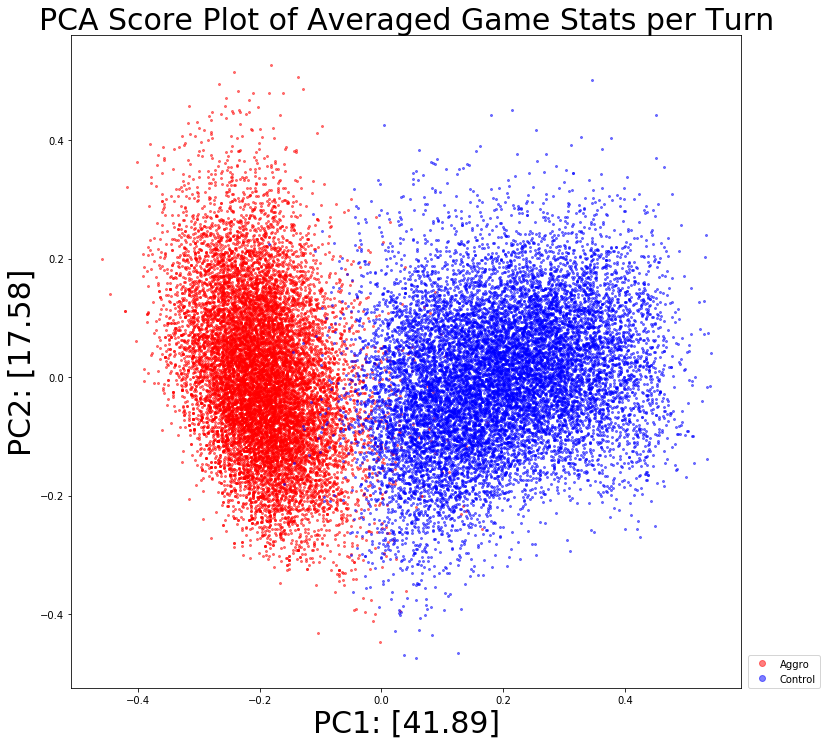

In [169]:
#scores = X_train_pca    #score
#pca_exvar              #coeff
#labels = list(X.columns)

save_figure = True
x1_scores = X_train_pca.iloc[:, 0]
x2_scores = X_train_pca.iloc[:, 1]
n = pca_exvar.shape[0] # 13 columns in the original data set

x1_scale = 1.0 / (x1_scores.max() - x1_scores.min())
x2_scale = 1.0 / (x2_scores.max() - x2_scores.min())

#plt.scatter(x1_scores * x1_scale, x2_scores * x2_scale, s=5, c='grey', alpha=0.4)
plt.plot(temp_agg0['PC1']*x1_scale, temp_agg0['PC2']*x2_scale, 'o', c='red', markersize=2, alpha=0.5, label='Aggro')
plt.plot(temp_con1['PC1']*x1_scale, temp_con1['PC2']*x2_scale, 'o', c='blue', markersize=2, alpha=0.5, label='Control')
plt.gcf().set_size_inches(12, 12)
plt.title('PCA Score Plot of Averaged Game Stats per Turn', fontdict={'fontsize':30})
plt.xlabel('PC1: [{:.2f}]'.format(pc1_explainedV), fontdict={'fontsize':30})
plt.ylabel('PC2: [{:.2f}]'.format(pc2_explainedV), fontdict={'fontsize':30})
lgnd = plt.legend(loc=(1.01,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots\\base_pca_color.pdf', format='pdf')
plt.show()    #SpellsPlayed and Hero Power are overlapping

#### Logistic Regression

In [170]:
logreg_pca = LogisticRegression(solver='liblinear', random_state=4, penalty='l2', C=10)
logreg_pca.fit(X_train_pca, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=4, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [171]:
logreg_pca_preds = logreg_pca.predict(X_test_pca)

In [172]:
logreg_pca_predsDF = pd.DataFrame(X_test_pca.copy(), columns=['PC1', 'PC2'])
logreg_pca_predsDF.insert(0, 'y', logreg_pca_preds)
logreg_pca_predsDF.head(10)

y       PC1       PC2
0  1.0  2.073118  1.037934
1  0.0 -2.456970  2.354296
2  0.0 -1.815905  0.146077
3  0.0 -1.817345 -0.737521
4  0.0 -2.902003  1.511012
5  0.0 -1.685094 -2.212089
6  1.0  1.407774 -1.293412
7  1.0  2.134192  0.935209
8  0.0 -1.997574 -0.614296
9  0.0 -1.901010  2.691188

In [173]:
logreg_pca_predsDF0 = logreg_pca_predsDF.loc[(logreg_pca_predsDF['y']==0)]
logreg_pca_predsDF1 = logreg_pca_predsDF.loc[(logreg_pca_predsDF['y']==1)]

Saved PCA plot to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\pca-plots\base_pca_pred_LR.pdf


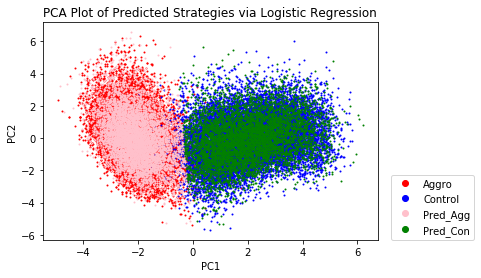

In [174]:
save_figure = True
pca_output_base2 = os.path.join(pca_output, 'base_pca_pred_LR.pdf')
#aggro is 0, control is 1
plt.plot(temp_agg0['PC1'], temp_agg0['PC2'], 'o', c='red', markersize=1, label='Aggro')
plt.plot(temp_con1['PC1'], temp_con1['PC2'], 'o', c='blue', markersize=1, label='Control')
plt.plot(logreg_pca_predsDF0['PC1'], logreg_pca_predsDF0['PC2'], 'o', c='pink', markersize=1, label='Pred_Agg')
plt.plot(logreg_pca_predsDF1['PC1'], logreg_pca_predsDF1['PC2'], 'o', c='green', markersize=1, label='Pred_Con')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==0].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==0].index), 1], 'o', c='blue')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==1].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==1].index), 1], 'x', c='red')
#plt.plot(X_test_pca[:, 0], X_test_pca[:, 1], 'x', c='red')
plt.title('PCA Plot of Predicted Strategies via Logistic Regression')
plt.xlabel('PC1')
plt.ylabel('PC2')
lgnd = plt.legend(loc=(1.04,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig(pca_output_base2, format='pdf', bbox_extra_artists=(lgnd,), bbox_inches='tight')
    print('Saved PCA plot to', pca_output_base2)
plt.show()

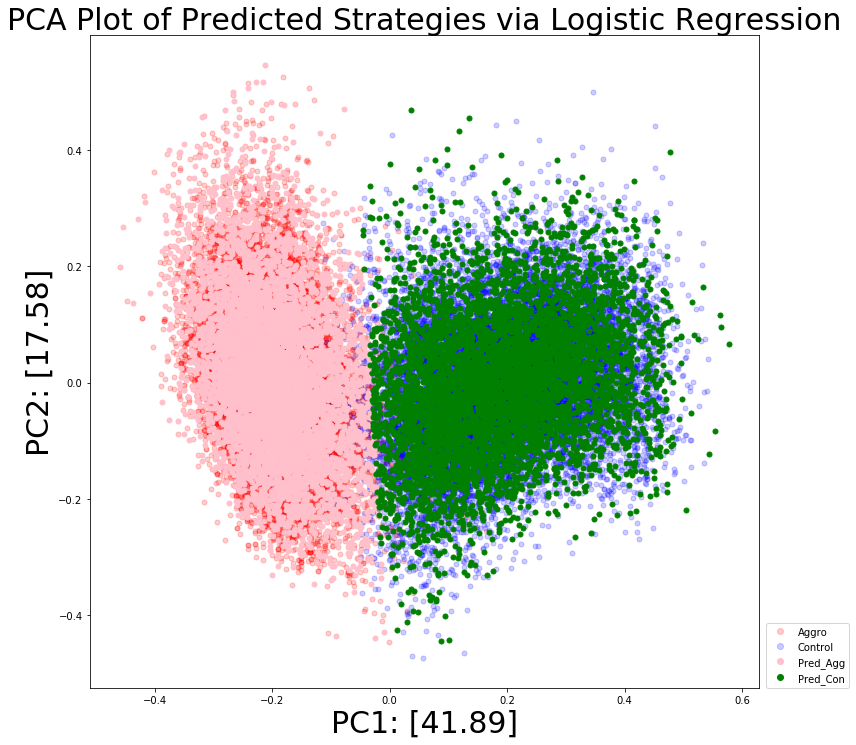

In [176]:
#scores = X_train_pca    #score
#pca_exvar              #coeff
#labels = list(X.columns)

save_figure = True
x1_scores = X_train_pca.iloc[:, 0]
x2_scores = X_train_pca.iloc[:, 1]
n = pca_exvar.shape[0] # 13 columns in the original data set

x1_scale = 1.0 / (x1_scores.max() - x1_scores.min())
x2_scale = 1.0 / (x2_scores.max() - x2_scores.min())

#plt.scatter(x1_scores * x1_scale, x2_scores * x2_scale, s=5, c='grey', alpha=0.4)
plt.plot(temp_agg0['PC1']*x1_scale, temp_agg0['PC2']*x2_scale, 'o', c='red', markersize=5, alpha=0.2, label='Aggro')
plt.plot(temp_con1['PC1']*x1_scale, temp_con1['PC2']*x2_scale, 'o', c='blue', markersize=5, alpha=0.2, label='Control')
plt.plot(logreg_pca_predsDF0['PC1']*x1_scale, logreg_pca_predsDF0['PC2']*x2_scale, 'o', c='pink', markersize=5, label='Pred_Agg')
plt.plot(logreg_pca_predsDF1['PC1']*x1_scale, logreg_pca_predsDF1['PC2']*x2_scale, 'o', c='green', markersize=5, label='Pred_Con')
plt.gcf().set_size_inches(12, 12)
plt.title('PCA Plot of Predicted Strategies via Logistic Regression', fontdict={'fontsize':30})
plt.xlabel('PC1: [{:.2f}]'.format(pc1_explainedV), fontdict={'fontsize':30})
plt.ylabel('PC2: [{:.2f}]'.format(pc2_explainedV), fontdict={'fontsize':30})
lgnd = plt.legend(loc=(1.01,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots\\base_pca_predTest-LR.pdf', format='pdf')
plt.show()    #SpellsPlayed and Hero Power are overlapping

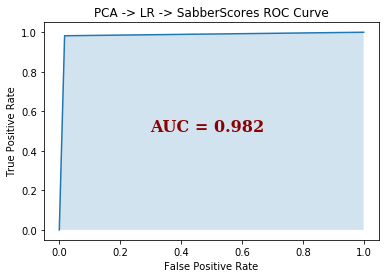

In [177]:
make_roc_curve(y_test, logreg_pca_preds, 'PCA -> LR -> SabberScores')

In [178]:
X_test_pcaNN = pca.transform(X_test_NN)
logreg_pca_predsNN = logreg_pca.predict(X_test_pcaNN)
logreg_pca_predsNNDF = pd.DataFrame(X_test_pcaNN, columns=['PC1', 'PC2'])
logreg_pca_predsNNDF.insert(0, 'y', logreg_pca_predsNN)
logreg_pca_predsNNDF.head(10)

NameError: name 'X_test_NN' is not defined

In [213]:
logreg_pca_predsDFNN0 = logreg_pca_predsNNDF.loc[(logreg_pca_predsNNDF['y']==0)]
logreg_pca_predsDFNN1 = logreg_pca_predsNNDF.loc[(logreg_pca_predsNNDF['y']==1)]
print(logreg_pca_predsDFNN0.shape)
print(logreg_pca_predsDFNN1.shape)

(1490, 3)
(4485, 3)


In [ ]:
save_figure = False
pca_output_base2 = os.path.join(pca_output, 'base_pca_pred_nets_LR.pdf')
#aggro is 0, control is 1
plt.plot(temp_agg0['PC1'], temp_agg0['PC2'], 'o', c='red', markersize=1, label='Aggro')
plt.plot(temp_con1['PC1'], temp_con1['PC2'], 'o', c='blue', markersize=1, label='Control')
plt.plot(logreg_pca_predsDFNN0['PC1'], logreg_pca_predsDFNN0['PC2'], 'o', c='orange', markersize=1, label='Pred_Agg')
plt.plot(logreg_pca_predsDFNN1['PC1'], logreg_pca_predsDFNN1['PC2'], 'o', c='purple', markersize=1, label='Pred_Con')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==0].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==0].index), 1], 'o', c='blue')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==1].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==1].index), 1], 'x', c='red')
#plt.plot(X_test_pca[:, 0], X_test_pca[:, 1], 'x', c='red')
plt.title('PCA Plot of Predicted Evolved Strategies via Logistic Regression')
plt.xlabel('PC1')
plt.ylabel('PC2')
lgnd = plt.legend(loc=(1.04,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig(pca_output_base2, format='pdf', bbox_extra_artists=(lgnd,), bbox_inches='tight')
    print('Saved PCA plot to', pca_output_base2)
plt.show()

In [ ]:
#scores = X_train_pca    #score
#pca_exvar              #coeff
#labels = list(X.columns)

save_figure = False 
x1_scores = X_train_pca.iloc[:, 0]
x2_scores = X_train_pca.iloc[:, 1]
n = pca_exvar.shape[0] # 13 columns in the original data set

x1_scale = 1.0 / (x1_scores.max() - x1_scores.min())
x2_scale = 1.0 / (x2_scores.max() - x2_scores.min())

#plt.scatter(x1_scores * x1_scale, x2_scores * x2_scale, s=5, c='grey', alpha=0.4)
plt.plot(temp_agg0['PC1']*x1_scale, temp_agg0['PC2']*x2_scale, 'o', c='red', markersize=5, alpha=0.2, label='Aggro')
plt.plot(temp_con1['PC1']*x1_scale, temp_con1['PC2']*x2_scale, 'o', c='blue', markersize=5, alpha=0.2, label='Control')
plt.plot(logreg_pca_predsDFNN0['PC1']*x1_scale, logreg_pca_predsDFNN0['PC2']*x2_scale, 'o', c='orange', markersize=5, label='Pred_Agg')
plt.plot(logreg_pca_predsDFNN1['PC1']*x1_scale, logreg_pca_predsDFNN1['PC2']*x2_scale, 'o', c='purple', markersize=5, label='Pred_Con')
plt.gcf().set_size_inches(12, 12)
plt.title('PCA Score Plot of Predicted Gameplay Strategies', fontdict={'fontsize':30})
plt.xlabel('PC1: [{:.2f}]'.format(pc1_explainedV), fontdict={'fontsize':30})
plt.ylabel('PC2: [{:.2f}]'.format(pc2_explainedV), fontdict={'fontsize':30})
lgnd = plt.legend(loc=(1.01,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots\\base_pca_predNN_LR.pdf', format='pdf')
plt.show()    #SpellsPlayed and Hero Power are overlapping

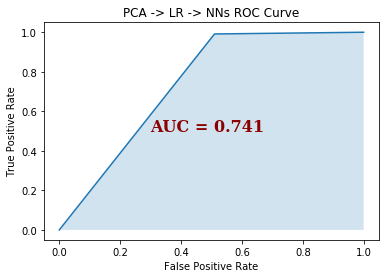

In [216]:
make_roc_curve(y_test_NN, logreg_pca_predsNN, 'PCA -> LR -> NNs')

In [ ]:
elites_stats

In [228]:
X_e = sc.transform(elites_stats.iloc[:, 2:]) #Stats columns
print(X_e.shape)

y_e = elites_stats.iloc[:, 1] #PlayerStrategy
print(y_e.shape)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_e, y_e, test_size=0.3, stratify=y_e, random_state=4
)

(1176, 13)
(1176,)


In [229]:
X_test_pcae = pca.transform(X_test_e)
logreg_pca_predse = logreg_pca.predict(X_test_pcae)
logreg_pca_predseDF = pd.DataFrame(X_test_pcae, columns=['PC1', 'PC2'])
logreg_pca_predseDF.insert(0, 'y', logreg_pca_predse)
logreg_pca_predseDF.head(10)

y       PC1       PC2
0  1.0  1.013639 -0.205365
1  0.0 -1.976987  0.043472
2  1.0  1.339154  1.825542
3  1.0  1.488381  1.178545
4  1.0  0.973740 -1.278320
5  1.0  1.331273  0.846822
6  1.0  0.599409  0.904494
7  1.0  1.618593  2.321509
8  1.0  1.471056  3.021395
9  1.0  1.767802  0.857892

In [230]:
logreg_pca_predsDFe0 = logreg_pca_predseDF.loc[(logreg_pca_predseDF['y']==0)]
logreg_pca_predsDFe1 = logreg_pca_predseDF.loc[(logreg_pca_predseDF['y']==1)]
print(logreg_pca_predsDFe0.shape)
print(logreg_pca_predsDFe1.shape)

(52, 3)
(301, 3)


In [ ]:
save_figure = False
pca_output_base2 = os.path.join(pca_output, 'base_pca_pred_nets_LR_elites.pdf')
#aggro is 0, control is 1
plt.plot(temp_agg0['PC1'], temp_agg0['PC2'], 'o', c='red', markersize=1, label='Aggro')
plt.plot(temp_con1['PC1'], temp_con1['PC2'], 'o', c='blue', markersize=1, label='Control')
plt.plot(logreg_pca_predsDFe0['PC1'], logreg_pca_predsDFe0['PC2'], 'o', c='orange', markersize=5, label='Pred_EAgg')
plt.plot(logreg_pca_predsDFe1['PC1'], logreg_pca_predsDFe1['PC2'], 'o', c='purple', markersize=5, label='Pred_ECon')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==0].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==0].index), 1], 'o', c='blue')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==1].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==1].index), 1], 'x', c='red')
#plt.plot(X_test_pca[:, 0], X_test_pca[:, 1], 'x', c='red')
plt.title('PCA Plot of Predicted Strategies via Logistic Regression - Elites')
plt.xlabel('PC1')
plt.ylabel('PC2')
lgnd = plt.legend(loc=(1.04,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig(pca_output_base2, format='pdf', bbox_extra_artists=(lgnd,), bbox_inches='tight')
    print('Saved PCA plot to', pca_output_base2)
plt.show()

In [ ]:
#scores = X_train_pca    #score
#pca_exvar              #coeff
#labels = list(X.columns)

save_figure = False 
x1_scores = X_train_pca.iloc[:, 0]
x2_scores = X_train_pca.iloc[:, 1]
n = pca_exvar.shape[0] # 13 columns in the original data set

x1_scale = 1.0 / (x1_scores.max() - x1_scores.min())
x2_scale = 1.0 / (x2_scores.max() - x2_scores.min())

#plt.scatter(x1_scores * x1_scale, x2_scores * x2_scale, s=5, c='grey', alpha=0.4)
plt.plot(temp_agg0['PC1']*x1_scale, temp_agg0['PC2']*x2_scale, 'o', c='red', markersize=5, alpha=0.2, label='Aggro')
plt.plot(temp_con1['PC1']*x1_scale, temp_con1['PC2']*x2_scale, 'o', c='blue', markersize=5, alpha=0.2, label='Control')
plt.plot(logreg_pca_predsDFe0['PC1']*x1_scale, logreg_pca_predsDFe0['PC2']*x2_scale, 'o', c='orange', markersize=10, label='Pred_Agg')
plt.plot(logreg_pca_predsDFe1['PC1']*x1_scale, logreg_pca_predsDFe1['PC2']*x2_scale, 'o', c='purple', markersize=10, label='Pred_Con')
plt.gcf().set_size_inches(12, 12)
plt.title('PCA Score Plot of Averaged Game Stats per Turn - Elites', fontdict={'fontsize':30})
plt.xlabel('PC1: [{:.2f}]'.format(pc1_explainedV), fontdict={'fontsize':30})
plt.ylabel('PC2: [{:.2f}]'.format(pc2_explainedV), fontdict={'fontsize':30})
lgnd = plt.legend(loc=(1.01,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots\\base_pca_predNN_LR.pdf', format='pdf')
plt.show()    #SpellsPlayed and Hero Power are overlapping

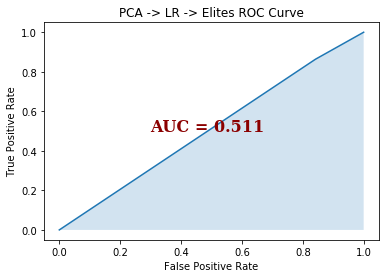

In [236]:
make_roc_curve(y_test_e, logreg_pca_predse, 'PCA -> LR -> Elites')

### Support Vector Machine

In [181]:
svc_pca = LinearSVC(loss='squared_hinge', random_state=4, dual=False, penalty='l2', C=1)
svc_pca.fit(X_train_pca, y_train)

LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=4, tol=0.0001,
     verbose=0)

In [182]:
svc_pca_preds = svc_pca.predict(X_test_pca)

In [183]:
svc_pca_predsDF = pd.DataFrame(X_test_pca.copy(), columns=['PC1', 'PC2'])
svc_pca_predsDF.insert(0, 'y', svc_pca_preds)
svc_pca_predsDF.head(10)

y       PC1       PC2
0  1.0  2.073118  1.037934
1  0.0 -2.456970  2.354296
2  0.0 -1.815905  0.146077
3  0.0 -1.817345 -0.737521
4  0.0 -2.902003  1.511012
5  0.0 -1.685094 -2.212089
6  1.0  1.407774 -1.293412
7  1.0  2.134192  0.935209
8  0.0 -1.997574 -0.614296
9  0.0 -1.901010  2.691188

In [184]:
svc_pca_predsDF0 = svc_pca_predsDF.loc[(svc_pca_predsDF['y']==0)]
svc_pca_predsDF1 = svc_pca_predsDF.loc[(svc_pca_predsDF['y']==1)]

Saved PCA plot to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\pca-plots\base_pca_pred.pdf


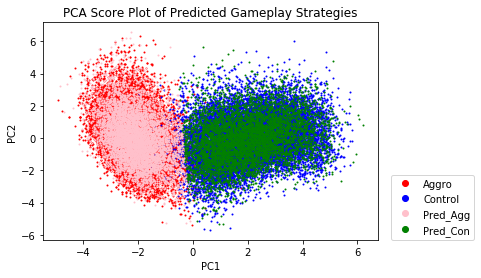

In [193]:
save_figure = True
pca_output_base2 = os.path.join(pca_output, 'base_pca_pred.pdf')
#aggro is 0, control is 1
plt.plot(temp_agg0['PC1'], temp_agg0['PC2'], 'o', c='red', markersize=1, label='Aggro')
plt.plot(temp_con1['PC1'], temp_con1['PC2'], 'o', c='blue', markersize=1, label='Control')
plt.plot(svc_pca_predsDF0['PC1'], svc_pca_predsDF0['PC2'], 'o', c='pink', markersize=1, label='Pred_Agg')
plt.plot(svc_pca_predsDF1['PC1'], svc_pca_predsDF1['PC2'], 'o', c='green', markersize=1, label='Pred_Con')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==0].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==0].index), 1], 'o', c='blue')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==1].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==1].index), 1], 'x', c='red')
#plt.plot(X_test_pca[:, 0], X_test_pca[:, 1], 'x', c='red')
plt.title('PCA Score Plot of Predicted Gameplay Strategies')
plt.xlabel('PC1')
plt.ylabel('PC2')
lgnd = plt.legend(loc=(1.04,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig(pca_output_base2, format='pdf', bbox_extra_artists=(lgnd,), bbox_inches='tight')
    print('Saved PCA plot to', pca_output_base2)
plt.show()

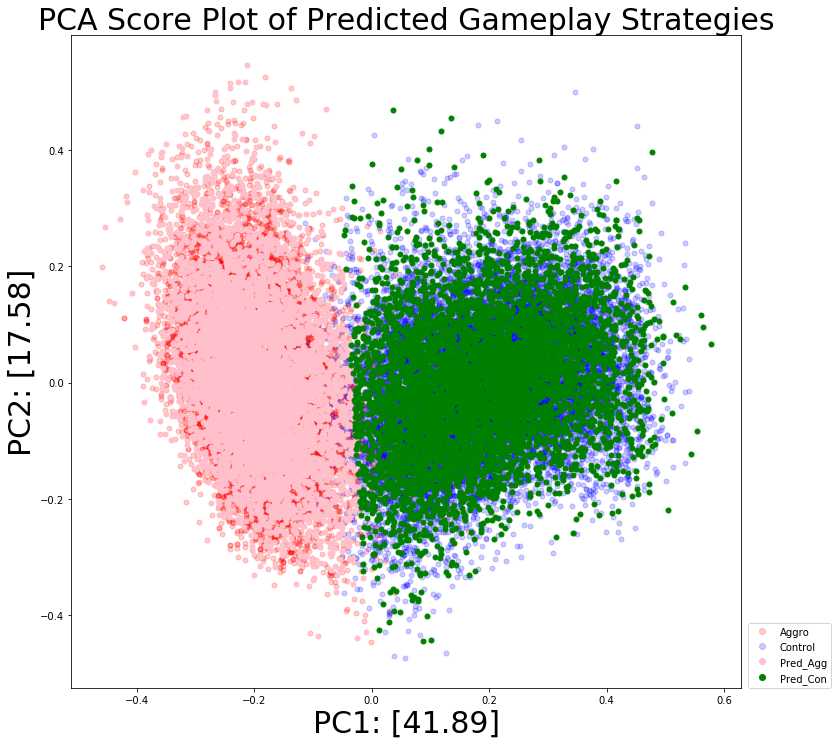

In [194]:
#scores = X_train_pca    #score
#pca_exvar              #coeff
#labels = list(X.columns)

save_figure = True
x1_scores = X_train_pca.iloc[:, 0]
x2_scores = X_train_pca.iloc[:, 1]
n = pca_exvar.shape[0] # 13 columns in the original data set

x1_scale = 1.0 / (x1_scores.max() - x1_scores.min())
x2_scale = 1.0 / (x2_scores.max() - x2_scores.min())

#plt.scatter(x1_scores * x1_scale, x2_scores * x2_scale, s=5, c='grey', alpha=0.4)
plt.plot(temp_agg0['PC1']*x1_scale, temp_agg0['PC2']*x2_scale, 'o', c='red', markersize=5, alpha=0.2, label='Aggro')
plt.plot(temp_con1['PC1']*x1_scale, temp_con1['PC2']*x2_scale, 'o', c='blue', markersize=5, alpha=0.2, label='Control')
plt.plot(svc_pca_predsDF0['PC1']*x1_scale, svc_pca_predsDF0['PC2']*x2_scale, 'o', c='pink', markersize=5, label='Pred_Agg')
plt.plot(svc_pca_predsDF1['PC1']*x1_scale, svc_pca_predsDF1['PC2']*x2_scale, 'o', c='green', markersize=5, label='Pred_Con')
plt.gcf().set_size_inches(12, 12)
plt.title('PCA Score Plot of Predicted Gameplay Strategies', fontdict={'fontsize':30})
plt.xlabel('PC1: [{:.2f}]'.format(pc1_explainedV), fontdict={'fontsize':30})
plt.ylabel('PC2: [{:.2f}]'.format(pc2_explainedV), fontdict={'fontsize':30})
lgnd = plt.legend(loc=(1.01,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots\\base_pca_predTest.pdf', format='pdf')
plt.show()    #SpellsPlayed and Hero Power are overlapping

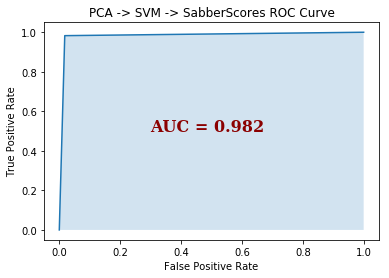

In [208]:
make_roc_curve(y_test, svc_pca_preds, 'PCA -> SVM -> SabberScores')

In [179]:
X_NN = sc.transform(nancstats.iloc[:, 2:]) #Stats columns
print(X_NN.shape)

y_NN = nancstats.iloc[:, 1] #PlayerStrategy
print(y_NN.shape)
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(
    X_NN, y_NN, test_size=0.3, stratify=y_NN, random_state=4
)

(19916, 13)
(19916,)


In [187]:
X_test_pcaNN = pca.transform(X_test_NN)
svc_pca_predsNN = svc_pca.predict(X_test_pcaNN)
svc_pca_predsNNDF = pd.DataFrame(X_test_pcaNN, columns=['PC1', 'PC2'])
svc_pca_predsNNDF.insert(0, 'y', svc_pca_predsNN)
svc_pca_predsNNDF.head(10)

y       PC1       PC2
0  1.0  1.277157 -1.130495
1  0.0 -1.547627  0.906277
2  0.0 -1.360413  0.195986
3  1.0  1.567409 -2.884844
4  1.0  4.957931  1.390916
5  1.0 -0.381496  2.941683
6  0.0 -0.703961  4.291155
7  1.0  2.073904 -2.635573
8  1.0  0.246523 -2.745023
9  0.0 -1.626847 -0.457932

In [188]:
svc_pca_predsDFNN0 = svc_pca_predsNNDF.loc[(svc_pca_predsNNDF['y']==0)]
svc_pca_predsDFNN1 = svc_pca_predsNNDF.loc[(svc_pca_predsNNDF['y']==1)]
print(svc_pca_predsDFNN0.shape)
print(svc_pca_predsDFNN1.shape)

(1489, 3)
(4486, 3)


Saved PCA plot to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\pca-plots\base_pca_pred_nets.pdf


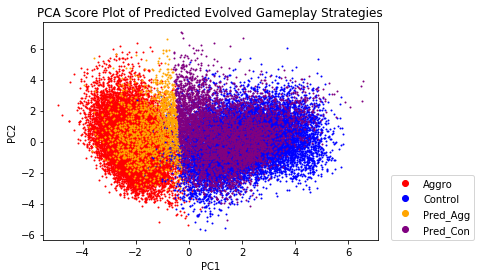

In [195]:
save_figure = True
pca_output_base2 = os.path.join(pca_output, 'base_pca_pred_nets.pdf')
#aggro is 0, control is 1
plt.plot(temp_agg0['PC1'], temp_agg0['PC2'], 'o', c='red', markersize=1, label='Aggro')
plt.plot(temp_con1['PC1'], temp_con1['PC2'], 'o', c='blue', markersize=1, label='Control')
plt.plot(svc_pca_predsDFNN0['PC1'], svc_pca_predsDFNN0['PC2'], 'o', c='orange', markersize=1, label='Pred_Agg')
plt.plot(svc_pca_predsDFNN1['PC1'], svc_pca_predsDFNN1['PC2'], 'o', c='purple', markersize=1, label='Pred_Con')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==0].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==0].index), 1], 'o', c='blue')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==1].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==1].index), 1], 'x', c='red')
#plt.plot(X_test_pca[:, 0], X_test_pca[:, 1], 'x', c='red')
plt.title('PCA Score Plot of Predicted Evolved Gameplay Strategies')
plt.xlabel('PC1')
plt.ylabel('PC2')
lgnd = plt.legend(loc=(1.04,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig(pca_output_base2, format='pdf', bbox_extra_artists=(lgnd,), bbox_inches='tight')
    print('Saved PCA plot to', pca_output_base2)
plt.show()

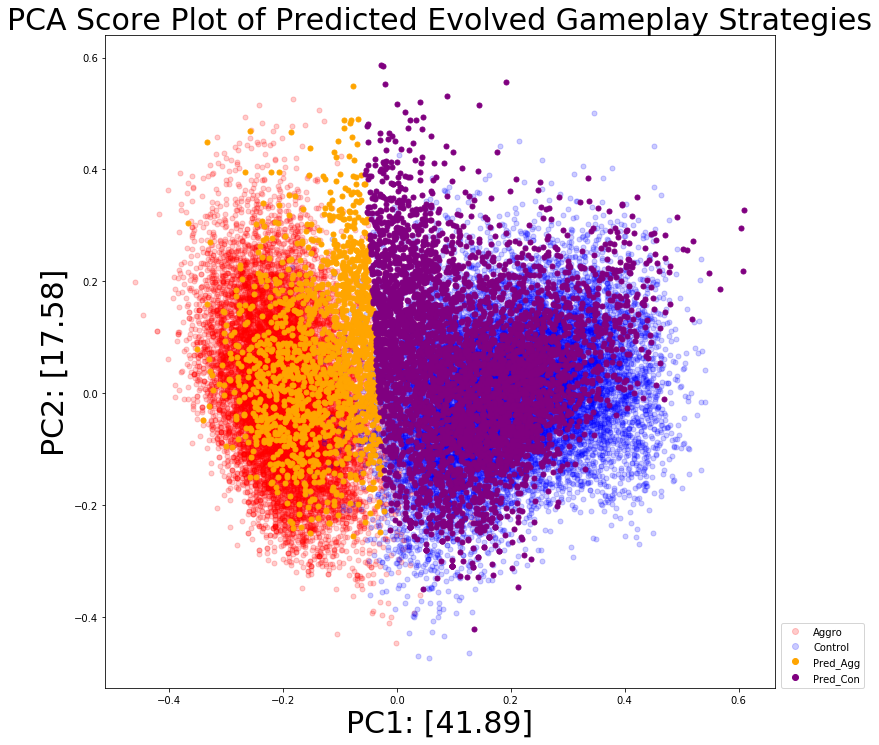

In [196]:
#scores = X_train_pca    #score
#pca_exvar              #coeff
#labels = list(X.columns)

save_figure = True
x1_scores = X_train_pca.iloc[:, 0]
x2_scores = X_train_pca.iloc[:, 1]
n = pca_exvar.shape[0] # 13 columns in the original data set

x1_scale = 1.0 / (x1_scores.max() - x1_scores.min())
x2_scale = 1.0 / (x2_scores.max() - x2_scores.min())

#plt.scatter(x1_scores * x1_scale, x2_scores * x2_scale, s=5, c='grey', alpha=0.4)
plt.plot(temp_agg0['PC1']*x1_scale, temp_agg0['PC2']*x2_scale, 'o', c='red', markersize=5, alpha=0.2, label='Aggro')
plt.plot(temp_con1['PC1']*x1_scale, temp_con1['PC2']*x2_scale, 'o', c='blue', markersize=5, alpha=0.2, label='Control')
plt.plot(svc_pca_predsDFNN0['PC1']*x1_scale, svc_pca_predsDFNN0['PC2']*x2_scale, 'o', c='orange', markersize=5, label='Pred_Agg')
plt.plot(svc_pca_predsDFNN1['PC1']*x1_scale, svc_pca_predsDFNN1['PC2']*x2_scale, 'o', c='purple', markersize=5, label='Pred_Con')
plt.gcf().set_size_inches(12, 12)
plt.title('PCA Score Plot of Predicted Evolved Gameplay Strategies', fontdict={'fontsize':30})
plt.xlabel('PC1: [{:.2f}]'.format(pc1_explainedV), fontdict={'fontsize':30})
plt.ylabel('PC2: [{:.2f}]'.format(pc2_explainedV), fontdict={'fontsize':30})
lgnd = plt.legend(loc=(1.01,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots\\base_pca_predNN.pdf', format='pdf')
plt.show()    #SpellsPlayed and Hero Power are overlapping

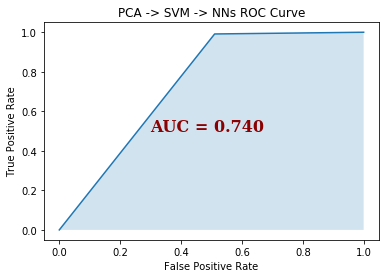

In [194]:
make_roc_curve(y_test_NN, svc_pca_predsNN, 'PCA -> SVM -> NNs')

In [237]:
svc_pca_predse = svc_pca.predict(X_test_pcae)
svc_pca_predseDF = pd.DataFrame(X_test_pcae, columns=['PC1', 'PC2'])
svc_pca_predseDF.insert(0, 'y', svc_pca_predse)
svc_pca_predseDF.head(10)

y       PC1       PC2
0  1.0  1.013639 -0.205365
1  0.0 -1.976987  0.043472
2  1.0  1.339154  1.825542
3  1.0  1.488381  1.178545
4  1.0  0.973740 -1.278320
5  1.0  1.331273  0.846822
6  1.0  0.599409  0.904494
7  1.0  1.618593  2.321509
8  1.0  1.471056  3.021395
9  1.0  1.767802  0.857892

In [238]:
svc_pca_predsDFe0 = svc_pca_predseDF.loc[(svc_pca_predseDF['y']==0)]
svc_pca_predsDFe1 = svc_pca_predseDF.loc[(svc_pca_predseDF['y']==1)]
print(svc_pca_predsDFe0.shape)
print(svc_pca_predsDFe1.shape)

(52, 3)
(301, 3)


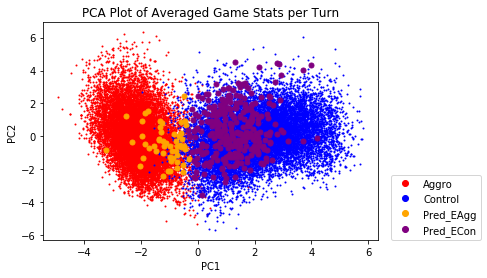

In [239]:
save_figure = False
pca_output_base2 = os.path.join(pca_output, 'base_pca_pred_nets.pdf')
#aggro is 0, control is 1
plt.plot(temp_agg0['PC1'], temp_agg0['PC2'], 'o', c='red', markersize=1, label='Aggro')
plt.plot(temp_con1['PC1'], temp_con1['PC2'], 'o', c='blue', markersize=1, label='Control')
plt.plot(svc_pca_predsDFe0['PC1'], svc_pca_predsDFe0['PC2'], 'o', c='orange', markersize=5, label='Pred_EAgg')
plt.plot(svc_pca_predsDFe1['PC1'], svc_pca_predsDFe1['PC2'], 'o', c='purple', markersize=5, label='Pred_ECon')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==0].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==0].index), 1], 'o', c='blue')
#plt.plot(X_train_pca.iloc[list(y_train.loc[y_train==1].index), 0], X_train_pca.iloc[list(y_train.loc[y_train==1].index), 1], 'x', c='red')
#plt.plot(X_test_pca[:, 0], X_test_pca[:, 1], 'x', c='red')
plt.title('PCA Plot of Averaged Game Stats per Turn')
plt.xlabel('PC1')
plt.ylabel('PC2')
lgnd = plt.legend(loc=(1.04,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig(pca_output_base2, format='pdf', bbox_extra_artists=(lgnd,), bbox_inches='tight')
    print('Saved PCA plot to', pca_output_base2)
plt.show()

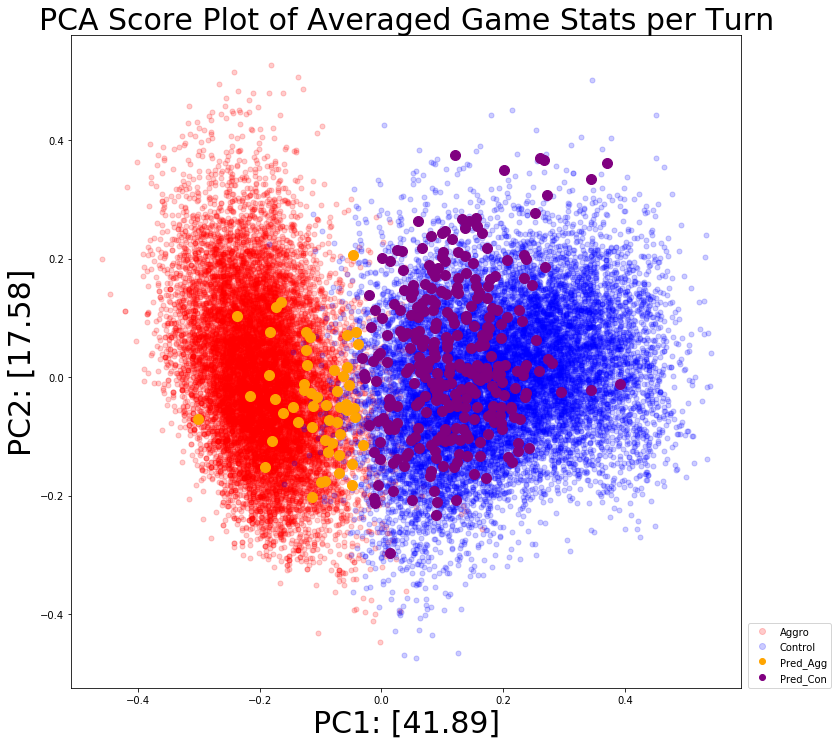

In [241]:
#scores = X_train_pca    #score
#pca_exvar              #coeff
#labels = list(X.columns)

save_figure = False
x1_scores = X_train_pca.iloc[:, 0]
x2_scores = X_train_pca.iloc[:, 1]
n = pca_exvar.shape[0] # 13 columns in the original data set

x1_scale = 1.0 / (x1_scores.max() - x1_scores.min())
x2_scale = 1.0 / (x2_scores.max() - x2_scores.min())

#plt.scatter(x1_scores * x1_scale, x2_scores * x2_scale, s=5, c='grey', alpha=0.4)
plt.plot(temp_agg0['PC1']*x1_scale, temp_agg0['PC2']*x2_scale, 'o', c='red', markersize=5, alpha=0.2, label='Aggro')
plt.plot(temp_con1['PC1']*x1_scale, temp_con1['PC2']*x2_scale, 'o', c='blue', markersize=5, alpha=0.2, label='Control')
plt.plot(svc_pca_predsDFe0['PC1']*x1_scale, svc_pca_predsDFe0['PC2']*x2_scale, 'o', c='orange', markersize=10, label='Pred_Agg')
plt.plot(svc_pca_predsDFe1['PC1']*x1_scale, svc_pca_predsDFe1['PC2']*x2_scale, 'o', c='purple', markersize=10, label='Pred_Con')
plt.gcf().set_size_inches(12, 12)
plt.title('PCA Score Plot of Averaged Game Stats per Turn', fontdict={'fontsize':30})
plt.xlabel('PC1: [{:.2f}]'.format(pc1_explainedV), fontdict={'fontsize':30})
plt.ylabel('PC2: [{:.2f}]'.format(pc2_explainedV), fontdict={'fontsize':30})
lgnd = plt.legend(loc=(1.01,0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(6)
if save_figure:
    plt.savefig('C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\pca-plots\\base_pca_predNN.pdf', format='pdf')
plt.show()    #SpellsPlayed and Hero Power are overlapping

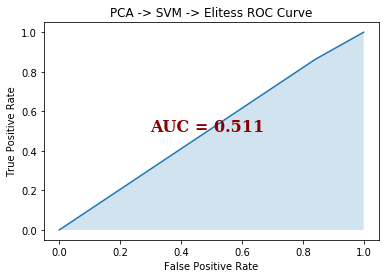

In [242]:
make_roc_curve(y_test_e, svc_pca_predse, 'PCA -> SVM -> Elites')

# Poor  Attempts at PCA (Ignore Until >CONTINUE)

In [17]:
agg_agg_folders[0]

'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups\\AvsA_1k0_Compiled\\Roffle-Roffle.csv'

In [124]:
def get_matchup_featurevectors(matchup_folders, min_numturns, na_fill):
    '''
    for aggro-aggro: pass min_numturns = 10
    '''
    all_dfs = []
    for folder in matchup_folders:
        cleaned_df = get_cleaned_match_df(folder)
        matchup_df = get_games_atleast_num_turns(cleaned_df, min_numturns)
        #(aa_rr_g10.groupby('GAME_COUNTER').count()['TURN_NO']<10).any()
        matchup_fv = gameto_featurevectors(matchup_df)
        all_dfs.append(matchup_fv)
    return pd.concat(all_dfs, axis=0, sort=False).fillna(na_fill)

In [125]:
"""agg_agg_fvset = get_matchup_featurevectors(agg_agg_folders, 10, -1)
agg_agg_fvset.shape

agg_agg_fvset.head(10)

thesis_output ='C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\'
pcaaa_output = os.path.join(thesis_output, 'pca-plots\\pcaaa.pdf')

'''pca = PCA(n_components=2)
X_trainaa_pca = pca.fit_transform(agg_agg_fvset)

plt.plot(X_trainaa_pca[:, 0], X_trainaa_pca[:, 1], 'o')
plt.title('PCA Plot of 8547 AAGames as Feature Vectors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig(pcaaa_output)
plt.show()'''"""

(8547, 440)

In [ ]:
'''#aa_rr_minturns = get_games_min_num_turns(aa_rr)
#fv_aa_rr = get_featurevector_gameset(aa_rr_minturns)


pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(fv_aa_rr)

plt.plot(X_train_pca[:, 0], X_train_pca[:, 1], 'o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

fv_aa_rr

aa_rr_comps, aa_rr_scaled = get_principal_components(fv_aa_rr)'''

In [ ]:
'''aa_rr_comps.sort_values('PC-1-ABS', ascending=False)#.head()

aa_rr_comps.sort_values('PC-2-ABS', ascending=False).head()'''

In [ ]:
'''aa_rv = get_cleaned_match_df(agg_agg_folders[1])
aa_rv_minturns = get_games_min_num_turns(aa_rv)
fv_aa_rv = get_featurevector_gameset(aa_rv_minturns)
aa_rv_comps, aa_rv_scaled = get_principal_components(fv_aa_rv)
plt.scatter(aa_rv_scaled[:,0], aa_rv_scaled[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

aa_rr_comps.sort_values('PC-1-ABS', ascending=False).head()

aa_rv_comps.sort_values('PC-1-ABS', ascending=False)#.head()'''

In [ ]:
'''aa_rp = get_cleaned_match_df(agg_agg_folders[1])
aa_rp_minturns = get_games_min_num_turns(aa_rp)
fv_aa_rp = get_featurevector_gameset(aa_rp_minturns)
aa_rp_comps, aa_rp_scaled = get_principal_components(fv_aa_rp)
plt.scatter(aa_rp_scaled[:,0], aa_rp_scaled[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()'''

In [ ]:
'''ac_ro = get_cleaned_match_df(agg_con_folders[0])
ac_ro_minturns = get_games_min_num_turns(ac_ro)
fv_ac_ro = get_featurevector_gameset(ac_ro_minturns)


pca = PCA(n_components=2)
Xc_train_pca = pca.fit_transform(fv_ac_ro)

plt.plot(Xc_train_pca[:, 0], Xc_train_pca[:, 1], 'o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
'''








#ac_ro_comps, ac_ro_scaled = get_principal_components(fv_ac_ro)
#plt.scatter(ac_ro_scaled[:,0], ac_ro_scaled[:,1])
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.show()

In [ ]:
'''con_con_fvset = get_matchup_featurevectors(con_con_folders, 16, -1)
con_con_fvset.shape

thesis_output ='C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\'
pcacc_output = os.path.join(thesis_output, 'pca-plots\\pcacc.pdf')

pca = PCA(n_components=2)
X_traincc_pca = pca.fit_transform(con_con_fvset)

plt.plot(X_traincc_pca[:, 0], X_traincc_pca[:, 1], 'o')
plt.title('PCA Plot of 16089 CCGames as Feature Vectors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig(pcacc_output)
plt.show()'''

In [129]:
'''print(agg_agg_fvset.shape, con_con_fvset.shape)

print(agg_agg_fvset.shape[0] + con_con_fvset.shape[0])

mirror_df = pd.concat([agg_agg_fvset, con_con_fvset], axis=0, sort=False).fillna(-1)
mirror_df.shape

thesis_output ='C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\'
pcam_output = os.path.join(thesis_output, 'pca-plots\\pca-mirrors.pdf')

pca = PCA(n_components=2)
X_trainm_pca = pca.fit_transform(mirror_df)

plt.plot(X_trainm_pca[:, 0], X_trainm_pca[:, 1], 'o')
plt.title('PCA Plot of 24636 Mirror-Matchup Games as Feature Vectors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig(pcam_output)
plt.show()'''

(8547, 440) (16089, 1254)
24636


# CONTINUE

# Histograms of the Frequency of the Number of Turns

Note the histograms are saved to local folders

##### Aggro-Aggro

In [209]:
generate_histograms_score_matchup(agg_agg, 'AggroScoreVSAggroScore')

Roffle-Roffle (4071, 23)
Roffle-Viper (4216, 23)
Roffle-Pizza (4112, 23)
Roffle-Solegit (4177, 23)
Roffle-Wabeka (4323, 23)
Viper-Roffle (4221, 23)
Viper-Viper (4240, 23)
Viper-Pizza (4233, 23)
Viper-Solegit (4235, 23)
Viper-Wabeka (4509, 23)
Pizza-Roffle (4116, 23)
Pizza-Viper (4238, 23)
Pizza-Pizza (4216, 23)
Pizza-Solegit (4172, 23)
Pizza-Wabeka (4363, 23)
Solegit-Roffle (4088, 23)
Solegit-Viper (4263, 23)
Solegit-Pizza (4195, 23)
Solegit-Solegit (4162, 23)
Solegit-Wabeka (4371, 23)
Wabeka-Roffle (4373, 23)
Wabeka-Viper (4441, 23)
Wabeka-Pizza (4373, 23)
Wabeka-Solegit (4375, 23)
Wabeka-Wabeka (4664, 23)
Made directory: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\AggroScoreVSAggroScore
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\AggroScoreVSAggroScore\Roffle-Roffle-Hist.pdf
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sa

{'Roffle-Roffle':      GAME_COUNTER  TURN_NO
 0               1       12
 1               2       10
 2               3       11
 3               4        8
 4               5        9
 5               6       10
 6               7       11
 7               8       10
 8               9       10
 9              10       12
 10             11        9
 11             12        9
 12             13       10
 13             14       11
 14             15        9
 15             16       11
 16             17       12
 17             18        9
 18             19       10
 19             20       10
 20             21       11
 21             22        9
 22             23       11
 23             24       10
 24             25       10
 25             26        9
 26             27        9
 27             28        9
 28             29        9
 29             30       11
 ..            ...      ...
 359           360       13
 360           361       10
 361           362       10
 36

In [213]:
generate_histograms_score_entirematchup(agg_agg, 'AggroScoreVSAggroScore')

Roffle-Roffle (4071, 23)
Roffle-Viper (4216, 23)
Roffle-Pizza (4112, 23)
Roffle-Solegit (4177, 23)
Roffle-Wabeka (4323, 23)
Viper-Roffle (4221, 23)
Viper-Viper (4240, 23)
Viper-Pizza (4233, 23)
Viper-Solegit (4235, 23)
Viper-Wabeka (4509, 23)
Pizza-Roffle (4116, 23)
Pizza-Viper (4238, 23)
Pizza-Pizza (4216, 23)
Pizza-Solegit (4172, 23)
Pizza-Wabeka (4363, 23)
Solegit-Roffle (4088, 23)
Solegit-Viper (4263, 23)
Solegit-Pizza (4195, 23)
Solegit-Solegit (4162, 23)
Solegit-Wabeka (4371, 23)
Wabeka-Roffle (4373, 23)
Wabeka-Viper (4441, 23)
Wabeka-Pizza (4373, 23)
Wabeka-Solegit (4375, 23)
Wabeka-Wabeka (4664, 23)
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21]
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\AggroScoreVSAggroScore-Hist.pdf


In [ ]:
agg_agg_wins = get_matchups_winrates(agg_agg, ngames=390)

In [ ]:
aa_wr_df = get_winrates_for_matchup_asframe(agg_agg_wins)
aa_wr_df

In [ ]:
aa_wr_arr = aa_wr_df.values.reshape(25, 1)
aa_wr_arr

##### Aggro-Control

Note the histograms are saved to local folders

In [199]:
generate_histograms_score_matchup(agg_con, 'Aggro-Control')

Roffle-Orasha (7948, 23)
Roffle-Thij (7949, 23)
Roffle-Stonekeep (7368, 23)
Roffle-Slage (7603, 23)
Roffle-Krebs1996 (7237, 23)
Viper-Orasha (8250, 23)
Viper-Thij (8053, 23)
Viper-Stonekeep (7555, 23)
Viper-Slage (7729, 23)
Viper-Krebs1996 (7505, 23)
Pizza-Orasha (8099, 23)
Pizza-Thij (8023, 23)
Pizza-Stonekeep (7550, 23)
Pizza-Slage (7506, 23)
Pizza-Krebs1996 (7309, 23)
Solegit-Orasha (8062, 23)
Solegit-Thij (7726, 23)
Solegit-Stonekeep (7406, 23)
Solegit-Slage (7487, 23)
Solegit-Krebs1996 (7285, 23)
Wabeka-Orasha (8486, 23)
Wabeka-Thij (8367, 23)
Wabeka-Stonekeep (7401, 23)
Wabeka-Slage (7746, 23)
Wabeka-Krebs1996 (7909, 23)
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-Control\Roffle-Orasha-Hist.pdf
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-Control\Roffle-Thij-Hist.pdf
Wrote histogram to: C:\Users\watson\Documents\G

{'Roffle-Orasha':      GAME_COUNTER  TURN_NO
 0               1       22
 1               2       18
 2               3       20
 3               4       24
 4               5       18
 5               6       18
 6               7       16
 7               8       20
 8               9       13
 9              10       22
 10             11       22
 11             12       20
 12             13       18
 13             14       22
 14             15       20
 15             16       22
 16             17       18
 17             18       22
 18             19       28
 19             20       20
 20             21       20
 21             22       22
 22             23       22
 23             24       22
 24             25       18
 25             26       22
 26             27       24
 27             28       24
 28             29       22
 29             30       20
 ..            ...      ...
 359           360       22
 360           361       18
 361           362       26
 36

In [214]:
generate_histograms_score_entirematchup(agg_con, 'AggroScoreVSControlScore')

Roffle-Orasha (7948, 23)
Roffle-Thij (7949, 23)
Roffle-Stonekeep (7368, 23)
Roffle-Slage (7603, 23)
Roffle-Krebs1996 (7237, 23)
Viper-Orasha (8250, 23)
Viper-Thij (8053, 23)
Viper-Stonekeep (7555, 23)
Viper-Slage (7729, 23)
Viper-Krebs1996 (7505, 23)
Pizza-Orasha (8099, 23)
Pizza-Thij (8023, 23)
Pizza-Stonekeep (7550, 23)
Pizza-Slage (7506, 23)
Pizza-Krebs1996 (7309, 23)
Solegit-Orasha (8062, 23)
Solegit-Thij (7726, 23)
Solegit-Stonekeep (7406, 23)
Solegit-Slage (7487, 23)
Solegit-Krebs1996 (7285, 23)
Wabeka-Orasha (8486, 23)
Wabeka-Thij (8367, 23)
Wabeka-Stonekeep (7401, 23)
Wabeka-Slage (7746, 23)
Wabeka-Krebs1996 (7909, 23)
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41]
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\AggroScoreVSControlScore-Hist.pdf


In [ ]:
agg_con_wins = get_matchups_winrates(agg_con, ngames=390)

In [ ]:
agg_agg_matchups_arr = np.array(  ['{}{}'.format(m.split('-')[0][:2], m.split('-')[1][:2]) for m in list(agg_agg_wins.keys())] )
agg_con_matchups_arr = np.array(  ['{}{}'.format(m.split('-')[0][:2], m.split('-')[1][:2]) for m in list(agg_con_wins.keys())] )

In [ ]:
ac_wrdf = get_winrates_for_matchup_asframe(agg_con_wins)
ac_wrdf

In [ ]:
ac_wr_arr = ac_wrdf.values.reshape(25,1)
ac_wr_arr

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(121)
#plt.plot(np.arange(0,1, 0.04), aa_wr_arr, 'o', color='red', label='Agg-Agg')
plt.plot(agg_agg_matchups_arr, aa_wr_arr, 'o', color='red', label='Agg-Agg')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 0.8, 0.1))
plt.ylabel('Player 1 (Aggro) Winrate')
plt.subplot(122)
plt.plot(agg_con_matchups_arr, ac_wr_arr, 'o', color='blue', label='Agg-Con')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 0.8, 0.1))

plt.suptitle('Comparing Winrates for the Matchups Aggro-Aggro (Red) and Aggro-Control (Blue)')
plt.gcf().subplots_adjust(bottom=0.25)
#txt = 'The x-label shows the unique matchups from P1 to P2, where the players\' names are denoted by the first two letters of their name.'
#plt.gcf().text(0.5, -0.2, txt, ha='center')
plt.savefig('C:\\Users\\Main\\Documents\\GitHub\\Sabber_Work_2019F\\thesis-images\\comparing-winrates-base-scores.pdf')
plt.show()

In [ ]:
agg_con_matchups_arr

##### Control Control

In [201]:
generate_histograms_score_matchup(con_con, 'Control-Control')

Orasha-Orasha (10185, 23)
Orasha-Thij (10820, 23)
Orasha-Stonekeep (11015, 23)
Orasha-Slage (10149, 23)
Orasha-Krebs1996 (10633, 23)
Thijs-Orasha (10635, 23)
Thijs-Thij (11207, 23)
Thijs-Stonekeep (11851, 23)
Thijs-Slage (10618, 23)
Thijs-Krebs1996 (11341, 23)
Stonekeep-Orasha (11208, 23)
Stonekeep-Thij (11731, 23)
Stonekeep-Stonekeep (14230, 23)
Stonekeep-Slage (11070, 23)
Stonekeep-Krebs1996 (11875, 23)
Slage-Orasha (9987, 23)
Slage-Thij (10424, 23)
Slage-Stonekeep (11068, 23)
Slage-Slage (10072, 23)
Slage-Krebs1996 (10453, 23)
Krebs1996-Orasha (10857, 23)
Krebs1996-Thij (11415, 23)
Krebs1996-Stonekeep (11692, 23)
Krebs1996-Slage (10574, 23)
Krebs1996-Krebs1996 (11510, 23)
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Control-Control\Orasha-Orasha-Hist.pdf
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Control-Control\Orasha-Thij-His

{'Orasha-Orasha':      GAME_COUNTER  TURN_NO
 0               1       23
 1               2       23
 2               3       28
 3               4       22
 4               5       27
 5               6       27
 6               7       24
 7               8       26
 8               9       19
 9              10       27
 10             11       19
 11             12       21
 12             13       19
 13             14       32
 14             15       30
 15             16       32
 16             17       23
 17             18       17
 18             19       23
 19             20       26
 20             21       19
 21             22       28
 22             23       32
 23             24       32
 24             25       40
 25             26       42
 26             27       31
 27             28       19
 28             29       15
 29             30       25
 ..            ...      ...
 359           360       28
 360           361       27
 361           362       21
 36

In [215]:
generate_histograms_score_entirematchup(con_con, 'ControlScoreVSControlScore')

Orasha-Orasha (10185, 23)
Orasha-Thij (10820, 23)
Orasha-Stonekeep (11015, 23)
Orasha-Slage (10149, 23)
Orasha-Krebs1996 (10633, 23)
Thijs-Orasha (10635, 23)
Thijs-Thij (11207, 23)
Thijs-Stonekeep (11851, 23)
Thijs-Slage (10618, 23)
Thijs-Krebs1996 (11341, 23)
Stonekeep-Orasha (11208, 23)
Stonekeep-Thij (11731, 23)
Stonekeep-Stonekeep (14230, 23)
Stonekeep-Slage (11070, 23)
Stonekeep-Krebs1996 (11875, 23)
Slage-Orasha (9987, 23)
Slage-Thij (10424, 23)
Slage-Stonekeep (11068, 23)
Slage-Slage (10072, 23)
Slage-Krebs1996 (10453, 23)
Krebs1996-Orasha (10857, 23)
Krebs1996-Thij (11415, 23)
Krebs1996-Stonekeep (11692, 23)
Krebs1996-Slage (10574, 23)
Krebs1996-Krebs1996 (11510, 23)
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\

### Aggro vs NNA small

In [203]:
generate_histograms_score_matchup(agg_ana, 'Aggro-NNAggro_sm')

Roffle-NNRoffle (4433, 23)
Roffle-NNViper (4569, 23)
Roffle-NNPizza (4584, 23)
Roffle-NNSolegit (4487, 23)
Roffle-NNWabeka (4712, 23)
Viper-NNRoffle (4186, 23)
Viper-NNViper (4312, 23)
Viper-NNPizza (4074, 23)
Viper-NNSolegit (3950, 23)
Viper-NNWabeka (4252, 23)
Pizza-NNRoffle (3781, 23)
Pizza-NNViper (3866, 23)
Pizza-NNPizza (3930, 23)
Pizza-NNSolegit (3819, 23)
Pizza-NNWabeka (4052, 23)
Solegit-NNRoffle (3765, 23)
Solegit-NNViper (3923, 23)
Solegit-NNPizza (3887, 23)
Solegit-NNSolegit (3873, 23)
Solegit-NNWabeka (4079, 23)
Wabeka-NNRoffle (3971, 23)
Wabeka-NNViper (4158, 23)
Wabeka-NNPizza (4087, 23)
Wabeka-NNSolegit (4013, 23)
Wabeka-NNWabeka (4308, 23)
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-NNAggro_sm\Roffle-NNRoffle-Hist.pdf
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-NNAggro_sm\Roffle-NNViper-Hist.pdf
Wrote 

In [216]:
generate_histograms_score_entirematchup(agg_ana, 'AggroScoreVSEvoAggroScore_sm')

Roffle-NNRoffle (4433, 23)
Roffle-NNViper (4569, 23)
Roffle-NNPizza (4584, 23)
Roffle-NNSolegit (4487, 23)
Roffle-NNWabeka (4712, 23)
Viper-NNRoffle (4186, 23)
Viper-NNViper (4312, 23)
Viper-NNPizza (4074, 23)
Viper-NNSolegit (3950, 23)
Viper-NNWabeka (4252, 23)
Pizza-NNRoffle (3781, 23)
Pizza-NNViper (3866, 23)
Pizza-NNPizza (3930, 23)
Pizza-NNSolegit (3819, 23)
Pizza-NNWabeka (4052, 23)
Solegit-NNRoffle (3765, 23)
Solegit-NNViper (3923, 23)
Solegit-NNPizza (3887, 23)
Solegit-NNSolegit (3873, 23)
Solegit-NNWabeka (4079, 23)
Wabeka-NNRoffle (3971, 23)
Wabeka-NNViper (4158, 23)
Wabeka-NNPizza (4087, 23)
Wabeka-NNSolegit (4013, 23)
Wabeka-NNWabeka (4308, 23)
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 26]
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\AggroScoreVSEvoAggroScore_sm-Hist.pdf


### Aggro vs NNAggro Large

In [204]:
generate_histograms_score_matchup(agg_ana2, 'Aggro-NNAggro_lg')

Roffle-NNRoffle (4628, 23)
Roffle-NNViper (4656, 23)
Roffle-NNPizza (4648, 23)
Roffle-NNSolegit (4633, 23)
Roffle-NNWabeka (4821, 23)
Viper-NNRoffle (4629, 23)
Viper-NNViper (4655, 23)
Viper-NNPizza (4729, 23)
Viper-NNSolegit (4571, 23)
Viper-NNWabeka (4762, 23)
Pizza-NNRoffle (4388, 23)
Pizza-NNViper (4557, 23)
Pizza-NNPizza (4554, 23)
Pizza-NNSolegit (4549, 23)
Pizza-NNWabeka (4621, 23)
Solegit-NNRoffle (4418, 23)
Solegit-NNViper (4439, 23)
Solegit-NNPizza (4540, 23)
Solegit-NNSolegit (4472, 23)
Solegit-NNWabeka (4583, 23)
Wabeka-NNRoffle (4691, 23)
Wabeka-NNViper (4761, 23)
Wabeka-NNPizza (4753, 23)
Wabeka-NNSolegit (4742, 23)
Wabeka-NNWabeka (4996, 23)
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-NNAggro_lg\Roffle-NNRoffle-Hist.pdf
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-NNAggro_lg\Roffle-NNViper-Hist.pdf
Wrote 

In [217]:
generate_histograms_score_entirematchup(agg_ana2, 'AggroScoreVSEvoAggroScore_lg')

Roffle-NNRoffle (4628, 23)
Roffle-NNViper (4656, 23)
Roffle-NNPizza (4648, 23)
Roffle-NNSolegit (4633, 23)
Roffle-NNWabeka (4821, 23)
Viper-NNRoffle (4629, 23)
Viper-NNViper (4655, 23)
Viper-NNPizza (4729, 23)
Viper-NNSolegit (4571, 23)
Viper-NNWabeka (4762, 23)
Pizza-NNRoffle (4388, 23)
Pizza-NNViper (4557, 23)
Pizza-NNPizza (4554, 23)
Pizza-NNSolegit (4549, 23)
Pizza-NNWabeka (4621, 23)
Solegit-NNRoffle (4418, 23)
Solegit-NNViper (4439, 23)
Solegit-NNPizza (4540, 23)
Solegit-NNSolegit (4472, 23)
Solegit-NNWabeka (4583, 23)
Wabeka-NNRoffle (4691, 23)
Wabeka-NNViper (4761, 23)
Wabeka-NNPizza (4753, 23)
Wabeka-NNSolegit (4742, 23)
Wabeka-NNWabeka (4996, 23)
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25]
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\AggroScoreVSEvoAggroScore_lg-Hist.pdf


### Control vs NNControl Matchups

In [ ]:
con_cnc1, con2_cnc, con3_cnc

In [205]:
generate_histograms_score_matchup(con_cnc1, 'Control-NNControlsm')


Orasha-NNOrasha (9196, 23)
Orasha-NNThij (8412, 23)
Orasha-NNStonekeep (8352, 23)
Orasha-NNSlage (9281, 23)
Orasha-NNKrebs1996 (9308, 23)
Thijs-NNOrasha (9672, 23)
Thijs-NNThij (8823, 23)
Thijs-NNStonekeep (8878, 23)
Thijs-NNSlage (9511, 23)
Thijs-NNKrebs1996 (10054, 23)
Stonekeep-NNOrasha (9961, 23)
Stonekeep-NNThij (9082, 23)
Stonekeep-NNStonekeep (9277, 23)
Stonekeep-NNSlage (9752, 23)
Stonekeep-NNKrebs1996 (10229, 23)
Slage-NNOrasha (8681, 23)
Slage-NNThij (7980, 23)
Slage-NNStonekeep (7473, 23)
Slage-NNSlage (8869, 23)
Slage-NNKrebs1996 (8849, 23)
Krebs1996-NNOrasha (9143, 23)
Krebs1996-NNThij (7637, 23)
Krebs1996-NNStonekeep (7344, 23)
Krebs1996-NNSlage (9122, 23)
Krebs1996-NNKrebs1996 (9396, 23)
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Control-NNControlsm\Orasha-NNOrasha-Hist.pdf
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-ga

In [218]:
generate_histograms_score_entirematchup(con_cnc1, 'ControlScoreVSEvoControlScore_sm')

Orasha-NNOrasha (9196, 23)
Orasha-NNThij (8412, 23)
Orasha-NNStonekeep (8352, 23)
Orasha-NNSlage (9281, 23)
Orasha-NNKrebs1996 (9308, 23)
Thijs-NNOrasha (9672, 23)
Thijs-NNThij (8823, 23)
Thijs-NNStonekeep (8878, 23)
Thijs-NNSlage (9511, 23)
Thijs-NNKrebs1996 (10054, 23)
Stonekeep-NNOrasha (9961, 23)
Stonekeep-NNThij (9082, 23)
Stonekeep-NNStonekeep (9277, 23)
Stonekeep-NNSlage (9752, 23)
Stonekeep-NNKrebs1996 (10229, 23)
Slage-NNOrasha (8681, 23)
Slage-NNThij (7980, 23)
Slage-NNStonekeep (7473, 23)
Slage-NNSlage (8869, 23)
Slage-NNKrebs1996 (8849, 23)
Krebs1996-NNOrasha (9143, 23)
Krebs1996-NNThij (7637, 23)
Krebs1996-NNStonekeep (7344, 23)
Krebs1996-NNSlage (9122, 23)
Krebs1996-NNKrebs1996 (9396, 23)
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\ControlSc

In [206]:
generate_histograms_score_matchup(con2_cnc, 'Control-NNControllg1')


Orasha-NNOrasha (9311, 23)
Orasha-NNThij (9463, 23)
Orasha-NNStonekeep (9079, 23)
Orasha-NNSlage (8853, 23)
Orasha-NNKrebs1996 (9413, 23)
Thijs-NNOrasha (9914, 23)
Thijs-NNThij (9950, 23)
Thijs-NNStonekeep (10146, 23)
Thijs-NNSlage (9403, 23)
Thijs-NNKrebs1996 (10504, 23)
Stonekeep-NNOrasha (10405, 23)
Stonekeep-NNThij (10495, 23)
Stonekeep-NNStonekeep (11865, 23)
Stonekeep-NNSlage (9744, 23)
Stonekeep-NNKrebs1996 (11062, 23)
Slage-NNOrasha (9089, 23)
Slage-NNThij (9324, 23)
Slage-NNStonekeep (9083, 23)
Slage-NNSlage (8901, 23)
Slage-NNKrebs1996 (9206, 23)
Krebs1996-NNOrasha (9442, 23)
Krebs1996-NNThij (9088, 23)
Krebs1996-NNStonekeep (9028, 23)
Krebs1996-NNSlage (8986, 23)
Krebs1996-NNKrebs1996 (9741, 23)
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Control-NNControllg1\Orasha-NNOrasha-Hist.pdf
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-p

In [219]:
generate_histograms_score_entirematchup(con2_cnc, 'ControlScoreVSEvoControlScore_lg1')

Orasha-NNOrasha (9311, 23)
Orasha-NNThij (9463, 23)
Orasha-NNStonekeep (9079, 23)
Orasha-NNSlage (8853, 23)
Orasha-NNKrebs1996 (9413, 23)
Thijs-NNOrasha (9914, 23)
Thijs-NNThij (9950, 23)
Thijs-NNStonekeep (10146, 23)
Thijs-NNSlage (9403, 23)
Thijs-NNKrebs1996 (10504, 23)
Stonekeep-NNOrasha (10405, 23)
Stonekeep-NNThij (10495, 23)
Stonekeep-NNStonekeep (11865, 23)
Stonekeep-NNSlage (9744, 23)
Stonekeep-NNKrebs1996 (11062, 23)
Slage-NNOrasha (9089, 23)
Slage-NNThij (9324, 23)
Slage-NNStonekeep (9083, 23)
Slage-NNSlage (8901, 23)
Slage-NNKrebs1996 (9206, 23)
Krebs1996-NNOrasha (9442, 23)
Krebs1996-NNThij (9088, 23)
Krebs1996-NNStonekeep (9028, 23)
Krebs1996-NNSlage (8986, 23)
Krebs1996-NNKrebs1996 (9741, 23)
[9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49]
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Contr

In [207]:
generate_histograms_score_matchup(con3_cnc, 'Control-NNControllg2')


Orasha-NNOrasha (9096, 23)
Orasha-NNThij (9721, 23)
Orasha-NNStonekeep (8462, 23)
Orasha-NNSlage (8467, 23)
Orasha-NNKrebs1996 (8954, 23)
Thijs-NNOrasha (9987, 23)
Thijs-NNThij (9767, 23)
Thijs-NNStonekeep (9590, 23)
Thijs-NNSlage (8797, 23)
Thijs-NNKrebs1996 (9664, 23)
Stonekeep-NNOrasha (10246, 23)
Stonekeep-NNThij (10544, 23)
Stonekeep-NNStonekeep (11637, 23)
Stonekeep-NNSlage (9748, 23)
Stonekeep-NNKrebs1996 (10601, 23)
Slage-NNOrasha (8843, 23)
Slage-NNThij (9088, 23)
Slage-NNStonekeep (8691, 23)
Slage-NNSlage (8359, 23)
Slage-NNKrebs1996 (8881, 23)
Krebs1996-NNOrasha (9687, 23)
Krebs1996-NNThij (9759, 23)
Krebs1996-NNStonekeep (9083, 23)
Krebs1996-NNSlage (9014, 23)
Krebs1996-NNKrebs1996 (9509, 23)
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Control-NNControllg2\Orasha-NNOrasha-Hist.pdf
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per

In [220]:
generate_histograms_score_entirematchup(con3_cnc, 'ControlScoreVSEvoControlScore_lg2')

Orasha-NNOrasha (9096, 23)
Orasha-NNThij (9721, 23)
Orasha-NNStonekeep (8462, 23)
Orasha-NNSlage (8467, 23)
Orasha-NNKrebs1996 (8954, 23)
Thijs-NNOrasha (9987, 23)
Thijs-NNThij (9767, 23)
Thijs-NNStonekeep (9590, 23)
Thijs-NNSlage (8797, 23)
Thijs-NNKrebs1996 (9664, 23)
Stonekeep-NNOrasha (10246, 23)
Stonekeep-NNThij (10544, 23)
Stonekeep-NNStonekeep (11637, 23)
Stonekeep-NNSlage (9748, 23)
Stonekeep-NNKrebs1996 (10601, 23)
Slage-NNOrasha (8843, 23)
Slage-NNThij (9088, 23)
Slage-NNStonekeep (8691, 23)
Slage-NNSlage (8359, 23)
Slage-NNKrebs1996 (8881, 23)
Krebs1996-NNOrasha (9687, 23)
Krebs1996-NNThij (9759, 23)
Krebs1996-NNStonekeep (9083, 23)
Krebs1996-NNSlage (9014, 23)
Krebs1996-NNKrebs1996 (9509, 23)
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50]
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\Con

### Histograms for NNaggL vs NNconL

In [208]:
generate_histograms_score_matchup(nanc, 'NNAggro-NNControl_lg')


NNRoffle-NNOrasha (7041, 23)
NNRoffle-NNThij (6356, 23)
NNRoffle-NNStonekeep (5864, 23)
NNRoffle-NNSlage (6326, 23)
NNRoffle-NNKrebs1996 (6198, 23)
NNViper-NNOrasha (7536, 23)
NNViper-NNThij (7127, 23)
NNViper-NNStonekeep (6505, 23)
NNViper-NNSlage (6978, 23)
NNViper-NNKrebs1996 (6674, 23)
NNPizza-NNOrasha (7390, 23)
NNPizza-NNThij (7055, 23)
NNPizza-NNStonekeep (6510, 23)
NNPizza-NNSlage (6695, 23)
NNPizza-NNKrebs1996 (6712, 23)
NNSolegit-NNOrasha (7390, 23)
NNSolegit-NNThij (6774, 23)
NNSolegit-NNStonekeep (6106, 23)
NNSolegit-NNSlage (6658, 23)
NNSolegit-NNKrebs1996 (6539, 23)
NNWabeka-NNOrasha (7801, 23)
NNWabeka-NNThij (7406, 23)
NNWabeka-NNStonekeep (6620, 23)
NNWabeka-NNSlage (7024, 23)
NNWabeka-NNKrebs1996 (7156, 23)
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\NNAggro-NNControl_lg\NNRoffle-NNOrasha-Hist.pdf
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thes

In [221]:
generate_histograms_score_entirematchup(nanc, 'EvoAggroScoreVSEvoControlScore_lg')

NNRoffle-NNOrasha (7041, 23)
NNRoffle-NNThij (6356, 23)
NNRoffle-NNStonekeep (5864, 23)
NNRoffle-NNSlage (6326, 23)
NNRoffle-NNKrebs1996 (6198, 23)
NNViper-NNOrasha (7536, 23)
NNViper-NNThij (7127, 23)
NNViper-NNStonekeep (6505, 23)
NNViper-NNSlage (6978, 23)
NNViper-NNKrebs1996 (6674, 23)
NNPizza-NNOrasha (7390, 23)
NNPizza-NNThij (7055, 23)
NNPizza-NNStonekeep (6510, 23)
NNPizza-NNSlage (6695, 23)
NNPizza-NNKrebs1996 (6712, 23)
NNSolegit-NNOrasha (7390, 23)
NNSolegit-NNThij (6774, 23)
NNSolegit-NNStonekeep (6106, 23)
NNSolegit-NNSlage (6658, 23)
NNSolegit-NNKrebs1996 (6539, 23)
NNWabeka-NNOrasha (7801, 23)
NNWabeka-NNThij (7406, 23)
NNWabeka-NNStonekeep (6620, 23)
NNWabeka-NNSlage (7024, 23)
NNWabeka-NNKrebs1996 (7156, 23)
[7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35]
Wrote histogram to: C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\num-turns-per-game\EvoAggroScoreVSEvoControlScore_lg-H

### Collecting the data for Aggro-Control matchups

In [ ]:
acdf = agg_con.get_all_matchup_summary_data()
acdf

In [ ]:
acdf.loc[('Mean-Num-Turns', 'Roffle-Orasha')]

In [ ]:
mt1 = 'Roffle-Krebs1996'
mt2 = 'Roffle-Wabeka'
mean_dif = diff_in_means(acdf, sdf, mt1, mt2)
samp = samp_stat(acdf, sdf, mt1, mt2, 1.65)
print('mean dif', mean_dif)
print('z*samp_var', samp)

# Making CMA-ME Heatmaps

In [222]:
strategy_dir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\StrategySearchResults\\'
cmame_outputdir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\cmame-plots\\'

In [223]:
anasm_indiv_log = os.path.join(strategy_dir, 'Warlock_Net_AA_sm\\logs\\individual_log.csv')
anasm_indiv_log #this played 100 games on each ANN

'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\StrategySearchResults\\Warlock_Net_AA_sm\\logs\\individual_log.csv'

In [514]:
help(cma_me_ann_heatmap)

Help on function cma_me_ann_heatmap in module __main__:

cma_me_ann_heatmap(hm_d)
    ann_file = hm_d.get('Individual-Logs')
    strat1 = hm_d['Strat-1']
    strat2 = hm_d['Strat-2']
    ppath = hm_d.get('Output-Folder')
    ngames = hm_d.get('NGames', 100) #Num Games each ANN played
    nrow = hm_d.get('NRows', None) #Number of rows to read



Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Aggro-Aggro-5000x100.pdf


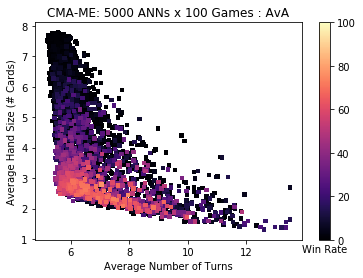

In [224]:
cma_me_ann_heatmap(
    {
        'Individual-Logs':anasm_indiv_log,
        'Strat-1':'Aggro',
        'Strat-2':'Aggro',
        'Output-Folder':cmame_outputdir,
        'NRows':5000
    }
)

In [225]:
analg_indiv_log = os.path.join(strategy_dir, 'Warlock_Net_AA_lg\\logs\\individual_log.csv')
#200 games each

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Aggro-Aggro-5000x200.pdf


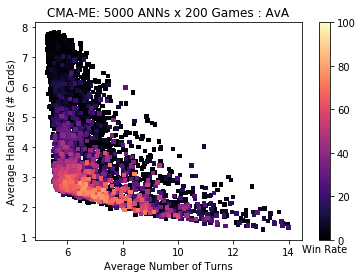

In [226]:
cma_me_ann_heatmap(
    {
        'Individual-Logs':analg_indiv_log,
        'Strat-1':'Aggro',
        'Strat-2':'Aggro',
        'Output-Folder':cmame_outputdir,
        'NRows':5000,
        'NGames':200
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Aggro-Aggro-10000x200.pdf


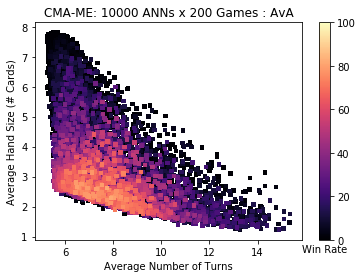

In [227]:
cma_me_ann_heatmap(
    {
        'Individual-Logs':analg_indiv_log,
        'Strat-1':'Aggro',
        'Strat-2':'Aggro',
        'Output-Folder':cmame_outputdir,
        'NRows':10000,
        'NGames':200
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Aggro-Aggro-20000x200.pdf


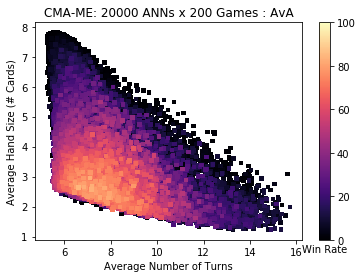

In [228]:
cma_me_ann_heatmap(
    {
        'Individual-Logs':analg_indiv_log,
        'Strat-1':'Aggro',
        'Strat-2':'Aggro',
        'Output-Folder':cmame_outputdir,
        'NRows':20000,
        'NGames':200
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Aggro-Aggro-30000x200.pdf


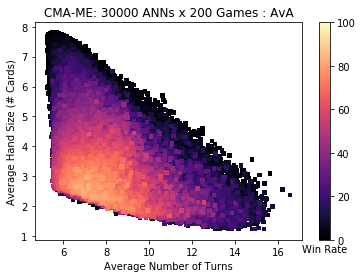

In [229]:
cma_me_ann_heatmap(
    {
        'Individual-Logs':analg_indiv_log,
        'Strat-1':'Aggro',
        'Strat-2':'Aggro',
        'Output-Folder':cmame_outputdir,
        'NRows':30000,
        'NGames':200
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Aggro-Aggro-40000x200.pdf


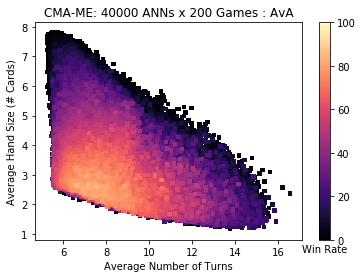

In [230]:
cma_me_ann_heatmap(
    {
        'Individual-Logs':analg_indiv_log,
        'Strat-1':'Aggro',
        'Strat-2':'Aggro',
        'Output-Folder':cmame_outputdir,
        'NRows':40000,
        'NGames':200
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Aggro-Aggro-50000x200.pdf


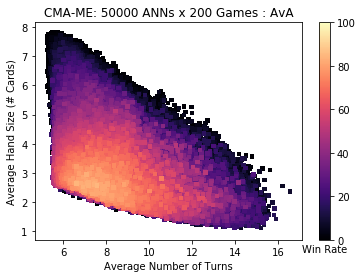

In [231]:
cma_me_ann_heatmap(
    {
        'Individual-Logs':analg_indiv_log,
        'Strat-1':'Aggro',
        'Strat-2':'Aggro',
        'Output-Folder':cmame_outputdir,
        'NRows':50000,
        'NGames':200
    }
)

In [232]:
cmame_outputdir

'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\cmame-plots\\'

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Control-Controlsm-5000x100.pdf


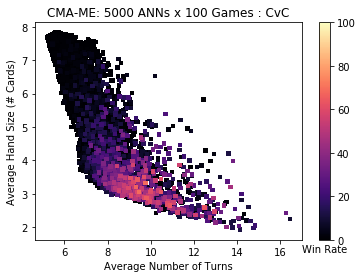

In [233]:
#small network played 100 games each
cma_me_ann_heatmap(
    {
        'Individual-Logs':os.path.join(strategy_dir, 'Warlock_Net_CC_sm\\logs\\individual_log.csv'),
        'Strat-1':'Control',
        'Strat-2':'Controlsm',
        'Output-Folder':cmame_outputdir
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Control-Control2-5000x100.pdf


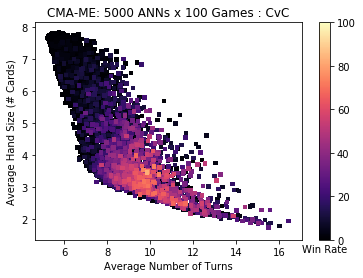

In [234]:
#second small network which also played 100 games each
cma_me_ann_heatmap(
    {
        'Individual-Logs':os.path.join(strategy_dir, 'CvsNNC_2.0\\logs\\individual_log.csv'),
        'Strat-1':'Control',
        'Strat-2':'Control2',
        'Output-Folder':cmame_outputdir,
        'NRows':5000,
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Control-Control-Large-5000x200.pdf


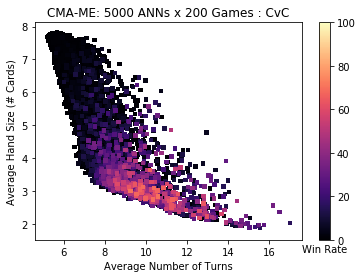

In [235]:
#200 games each
cma_me_ann_heatmap(
    {
        'Individual-Logs':os.path.join(strategy_dir, 'CvsNNC_Large\\logs\\individual_log.csv'),
        'Strat-1':'Control',
        'Strat-2':'Control-Large',
        'Output-Folder':cmame_outputdir,
        'NRows':5000,
        'NGames':200
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Control-Control-Large-10000x200.pdf


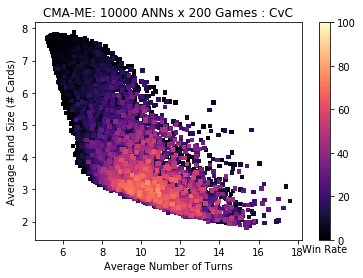

In [236]:
#200 games each
cma_me_ann_heatmap(
    {
        'Individual-Logs':os.path.join(strategy_dir, 'CvsNNC_Large\\logs\\individual_log.csv'),
        'Strat-1':'Control',
        'Strat-2':'Control-Large',
        'Output-Folder':cmame_outputdir,
        'NRows':10000,
        'NGames':200
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Control-Control-Large-18780x200.pdf


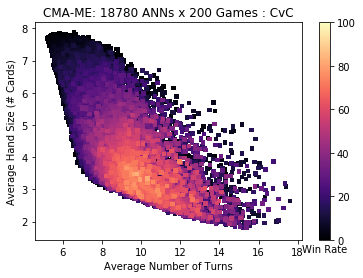

In [237]:
#200 games each
cma_me_ann_heatmap(
    {
        'Individual-Logs':os.path.join(strategy_dir, 'CvsNNC_Large\\logs\\individual_log.csv'),
        'Strat-1':'Control',
        'Strat-2':'Control-Large',
        'Output-Folder':cmame_outputdir,
        'NGames':200
    }
)

In [ ]:
fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=sub['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
plt.xlabel('Average Number of Turns')
plt.ylabel('Average Hand Size')
plt.title('CMA-ME')
plt.colorbar(sc1)
#plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=100), cmap='magma'), ax=ax)
plt.show()

# Scratch work to find color palettes

In [ ]:
from seaborn import color_palette
from seaborn import palplot
help(color_palette)

In [ ]:
colorslist = '''Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r'''
colors = colorslist.split(', ')
for c in colors[123:]:
    try:
        palplot(color_palette(c, 20))
    except:
        continue

In [ ]:
print(colors[126:131])